<a href="https://colab.research.google.com/github/HARICHANDANACS/LocalRepo/blob/main/amazonml1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Cell 1: Import necessary libraries
import os
import pandas as pd
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm

In [4]:
# Cell 2: Define constants and helper functions
DATASET_FOLDER = '/content/drive/MyDrive/Colab Notebooks/amazon ml/student_resource 3/dataset'

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

print("Constants and helper functions defined.")

Constants and helper functions defined.


In [5]:
# Cell 3: Load data
train_df = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Cell 4: Define the dataset
class ProductDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = download_image(row['image_link'])

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'entity_name': row['entity_name'],
            'group_id': row['group_id'],
            'index': row['index']
        }

# Cell 5: Define transforms and create datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ProductDataset(train_df, transform=transform)
test_dataset = ProductDataset(test_df, transform=transform)

# Cell 6: Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Datasets and DataLoaders created.")

# Cell 7: Define the model
class FeatureExtractionModel(nn.Module):
    def __init__(self, num_classes):
        super(FeatureExtractionModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

num_classes = len(train_df['entity_name'].unique())
model = FeatureExtractionModel(num_classes)
print("Model defined.")

# Cell 8: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Loss function and optimizer defined.")

Train data shape: (263859, 4)
Test data shape: (131187, 4)
Datasets and DataLoaders created.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


Model defined.
Loss function and optimizer defined.


In [6]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate through the training data
        for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
            images = batch['image'].to(device)
            labels = batch['entity_name'].to(device)  # You may need to encode this label using something like LabelEncoder

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100. * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return model

print("Training function defined.")


Training function defined.


In [7]:
def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            indices = batch['index']

            # Forward pass
            outputs = model(images)
            _, predicted = outputs.max(1)

            # Convert predicted labels back to actual entity names (or entity values in this case)
            for idx, pred in zip(indices, predicted):
                predictions.append({'index': idx.item(), 'prediction': entity_decoder[pred.item()]})

    return predictions

print("Evaluation function defined.")


Evaluation function defined.


In [8]:
import torch
print(torch.cuda.is_available())  # This should return True if CUDA is available

True


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device=device):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate through the training data
        for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
            images = batch['image'].to(device)
            labels = batch['entity_name'].to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100. * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return model


In [10]:
# Import necessary libraries
import torch

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


In [11]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)  # Move the model to the specified device (GPU or CPU)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate through the training data
        for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
            images = batch['image'].to(device)  # Move images to the device
            labels = batch['entity_name'].to(device)  # Move labels to the device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100. * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return model


In [12]:
def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)  # Move the model to the device
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disable gradient computation during inference
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['image'].to(device)  # Move images to the device
            indices = batch['index']

            # Forward pass
            outputs = model(images)
            _, predicted = outputs.max(1)

            # Convert predicted labels back to actual entity names (or entity values in this case)
            for idx, pred in zip(indices, predicted):
                predictions.append({
                    'index': idx.item(),
                    'prediction': entity_decoder[pred.item()]  # Decode the predicted class
                })

    return predictions


In [16]:
import pandas as pd

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon ml/student_resource 3/dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon ml/student_resource 3/dataset/test.csv')

# Print column names to verify
print("Train DataFrame Columns:", train_df.columns)
print("Test DataFrame Columns:", test_df.columns)


Train DataFrame Columns: Index(['image_link', 'group_id', 'entity_name', 'entity_value'], dtype='object')
Test DataFrame Columns: Index(['index', 'image_link', 'group_id', 'entity_name'], dtype='object')


In [17]:
def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)  # Move the model to the device
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disable gradient computation during inference
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['image'].to(device)  # Move images to the device
            indices = batch['index']  # Ensure 'index' is the correct column name

            # Forward pass
            outputs = model(images)
            _, predicted = outputs.max(1)

            # Convert predicted labels back to actual entity names
            for idx, pred in zip(indices, predicted):
                predictions.append({
                    'index': idx.item(),  # Use the correct column name
                    'prediction': entity_decoder[pred.item()]  # Decode the predicted class
                })

    return predictions


In [18]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)  # Move the model to the device
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = batch['image'].to(device)  # Move images to the device
            labels = batch['entity_name'].to(device)  # Move labels to the device

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss/len(train_loader)}")

    print("Training completed.")
    return model


In [20]:
def __getitem__(self, idx):
    row = self.dataframe.iloc[idx]
    image = download_image(row['image_link'])

    # Convert image to RGB
    image = image.convert('RGB')

    if self.transform:
        image = self.transform(image)

    return {
        'image': image,
        'entity_name': row['entity_name'],
        'group_id': row['group_id'],
        'index': row['index']
    }


In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Transformed Image Shape: torch.Size([3, 224, 224])


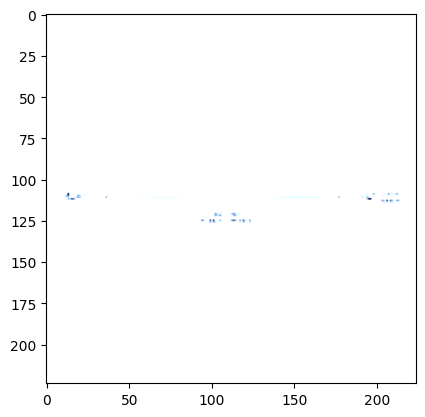

In [22]:
import matplotlib.pyplot as plt

# Load a sample image
sample_image = download_image(test_df.iloc[0]['image_link'])
sample_image = sample_image.convert('RGB')

# Apply transformations
sample_image = transform(sample_image)

# Check the shape
print("Transformed Image Shape:", sample_image.shape)

# Plot the image
plt.imshow(sample_image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
plt.show()


In [23]:
def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)  # Move the model to the device
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disable gradient computation during inference
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['image'].to(device)  # Move images to the device
            indices = batch['index']  # Access using the correct column name

            # Forward pass
            outputs = model(images)
            _, predicted = outputs.max(1)

            # Convert predicted labels back to actual entity names
            for idx, pred in zip(indices, predicted):
                predictions.append({
                    'index': idx.item(),  # Use the correct column name
                    'prediction': entity_decoder[pred.item()]  # Decode the predicted class
                })

    return predictions


In [26]:
def download_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image.convert('RGB')  # Ensure image is in RGB format


In [27]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [28]:
def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            indices = batch['index']

            # Debugging: Check tensor shape
            print("Image tensor shape:", images.shape)

            outputs = model(images)
            _, predicted = outputs.max(1)

            for idx, pred in zip(indices, predicted):
                predictions.append({
                    'index': idx.item(),
                    'prediction': entity_decoder[pred.item()]
                })

    return predictions


In [29]:
sample_image = download_image(test_df['image_link'].iloc[0])
sample_image = transform(sample_image)
print("Sample image tensor shape:", sample_image.shape)


Sample image tensor shape: torch.Size([3, 224, 224])


In [30]:
# Create a decoder from entity name to index
entity_decoder = {idx: name for idx, name in enumerate(train_df['entity_name'].unique())}

# Evaluate model
predictions = evaluate_model(model, test_loader, device='cuda')



Evaluating:   0%|          | 0/4100 [00:00<?, ?it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 2/4100 [00:05<3:10:34,  2.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 3/4100 [00:08<3:10:55,  2.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 4/4100 [00:12<3:46:36,  3.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 5/4100 [00:16<3:46:35,  3.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 6/4100 [00:19<3:51:13,  3.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 7/4100 [00:22<3:39:55,  3.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 8/4100 [00:24<3:12:25,  2.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 9/4100 [00:25<2:30:11,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 10/4100 [00:26<2:01:55,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 11/4100 [00:26<1:42:16,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 12/4100 [00:27<1:29:14,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 13/4100 [00:28<1:19:27,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 14/4100 [00:29<1:11:50,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 15/4100 [00:30<1:07:28,  1.01it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 16/4100 [00:31<1:04:34,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 17/4100 [00:31<1:02:24,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 18/4100 [00:32<1:00:16,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 19/4100 [00:33<58:22,  1.17it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   0%|          | 20/4100 [00:34<1:01:06,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 21/4100 [00:35<1:03:33,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 22/4100 [00:36<1:10:16,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 23/4100 [00:38<1:15:28,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 24/4100 [00:39<1:18:04,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 25/4100 [00:40<1:14:15,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 26/4100 [00:41<1:08:19,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 27/4100 [00:41<1:04:51,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 28/4100 [00:42<1:02:32,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 29/4100 [00:43<1:00:40,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 30/4100 [00:44<58:09,  1.17it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 31/4100 [00:45<56:47,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 32/4100 [00:45<54:59,  1.23it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 33/4100 [00:46<56:08,  1.21it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 34/4100 [00:47<55:10,  1.23it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 35/4100 [00:48<59:27,  1.14it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 36/4100 [00:49<1:03:29,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 37/4100 [00:50<1:05:00,  1.04it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 38/4100 [00:51<1:05:55,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 39/4100 [00:52<1:02:20,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 40/4100 [00:53<59:56,  1.13it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 41/4100 [00:54<57:43,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 42/4100 [00:54<57:51,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 43/4100 [00:55<56:02,  1.21it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 44/4100 [00:56<55:23,  1.22it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 45/4100 [00:57<57:37,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 46/4100 [00:58<59:37,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 47/4100 [00:59<1:03:12,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 48/4100 [01:00<1:06:02,  1.02it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 49/4100 [01:02<1:16:10,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 50/4100 [01:03<1:20:52,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|          | 51/4100 [01:06<2:04:59,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 52/4100 [01:09<2:24:30,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 53/4100 [01:12<2:42:59,  2.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 54/4100 [01:14<2:21:44,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 55/4100 [01:16<2:35:04,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 56/4100 [01:19<2:38:53,  2.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 57/4100 [01:20<2:22:47,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 58/4100 [01:22<2:09:17,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 59/4100 [01:23<1:56:25,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 60/4100 [01:25<1:50:54,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   1%|▏         | 61/4100 [01:26<1:40:34,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 62/4100 [01:27<1:31:08,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 63/4100 [01:28<1:24:11,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 64/4100 [01:29<1:25:27,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 65/4100 [01:30<1:25:46,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 66/4100 [01:32<1:24:36,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 67/4100 [01:33<1:20:42,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 68/4100 [01:34<1:18:23,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 69/4100 [01:35<1:16:10,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 70/4100 [01:36<1:12:55,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 71/4100 [01:37<1:10:26,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 72/4100 [01:38<1:11:52,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 73/4100 [01:39<1:09:22,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 74/4100 [01:40<1:07:37,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 75/4100 [01:41<1:05:50,  1.02it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 76/4100 [01:42<1:06:46,  1.00it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 77/4100 [01:43<1:09:07,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 78/4100 [01:44<1:12:34,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 79/4100 [01:45<1:14:56,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 80/4100 [01:46<1:16:11,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 81/4100 [01:47<1:15:52,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 82/4100 [01:48<1:12:52,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 83/4100 [01:49<1:08:34,  1.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 84/4100 [01:50<1:06:52,  1.00it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 85/4100 [01:51<1:06:38,  1.00it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 86/4100 [01:52<1:04:46,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 87/4100 [01:53<1:03:02,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 88/4100 [01:54<1:04:22,  1.04it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 89/4100 [01:55<1:05:15,  1.02it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 90/4100 [01:56<1:13:58,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 91/4100 [01:58<1:19:45,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 92/4100 [01:59<1:27:23,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 93/4100 [02:01<1:32:23,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 94/4100 [02:03<1:38:07,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 95/4100 [02:04<1:35:21,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 96/4100 [02:05<1:32:38,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 97/4100 [02:07<1:32:43,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 98/4100 [02:08<1:33:40,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 99/4100 [02:10<1:33:17,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 100/4100 [02:11<1:32:10,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 101/4100 [02:12<1:34:28,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   2%|▏         | 102/4100 [02:14<1:29:40,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 103/4100 [02:15<1:31:20,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 104/4100 [02:17<1:47:06,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 105/4100 [02:19<1:48:17,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 106/4100 [02:20<1:48:54,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 107/4100 [02:22<1:40:03,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 108/4100 [02:23<1:33:20,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 109/4100 [02:24<1:27:30,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 110/4100 [02:25<1:20:27,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 111/4100 [02:26<1:14:12,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 112/4100 [02:27<1:08:52,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 113/4100 [02:27<1:04:08,  1.04it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 114/4100 [02:28<59:41,  1.11it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 115/4100 [02:29<58:34,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 116/4100 [02:30<1:03:24,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 117/4100 [02:31<1:04:54,  1.02it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 118/4100 [02:32<1:07:06,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 119/4100 [02:33<1:07:06,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 120/4100 [02:34<1:09:04,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 121/4100 [02:35<1:06:37,  1.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 122/4100 [02:36<1:05:43,  1.01it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 123/4100 [02:37<1:02:42,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 124/4100 [02:38<1:00:53,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 125/4100 [02:39<59:18,  1.12it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 126/4100 [02:40<59:03,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 127/4100 [02:41<58:45,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 128/4100 [02:42<1:01:00,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 129/4100 [02:42<59:53,  1.11it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 130/4100 [02:43<59:43,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 131/4100 [02:44<59:13,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 132/4100 [02:45<1:06:26,  1.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 133/4100 [02:47<1:07:23,  1.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 134/4100 [02:48<1:11:49,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 135/4100 [02:49<1:10:04,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 136/4100 [02:50<1:04:03,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 137/4100 [02:50<1:01:14,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 138/4100 [02:51<1:01:30,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 139/4100 [02:52<58:31,  1.13it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 140/4100 [02:53<56:27,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 141/4100 [02:54<54:41,  1.21it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 142/4100 [02:55<1:04:05,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   3%|▎         | 143/4100 [02:56<1:06:23,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 144/4100 [02:57<1:06:32,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 145/4100 [02:58<1:07:08,  1.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 146/4100 [02:59<1:12:03,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 147/4100 [03:01<1:18:14,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 148/4100 [03:02<1:17:00,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 149/4100 [03:03<1:13:34,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 150/4100 [03:04<1:11:10,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 151/4100 [03:05<1:11:53,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 152/4100 [03:06<1:11:22,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▎         | 153/4100 [03:07<1:11:00,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 154/4100 [03:08<1:14:50,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 155/4100 [03:10<1:14:26,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 156/4100 [03:11<1:15:44,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 157/4100 [03:13<1:40:09,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 158/4100 [03:14<1:35:22,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 159/4100 [03:15<1:26:12,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 160/4100 [03:17<1:24:25,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 161/4100 [03:19<1:49:07,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 162/4100 [03:21<1:46:18,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 163/4100 [03:23<1:53:16,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 164/4100 [03:24<1:37:29,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 165/4100 [03:25<1:29:52,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 166/4100 [03:26<1:24:46,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 167/4100 [03:27<1:17:53,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 168/4100 [03:28<1:13:29,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 169/4100 [03:29<1:08:04,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 170/4100 [03:29<1:02:55,  1.04it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 171/4100 [03:30<59:40,  1.10it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 172/4100 [03:31<57:02,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 173/4100 [03:32<57:56,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 174/4100 [03:33<1:01:45,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 175/4100 [03:34<1:00:32,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 176/4100 [03:35<58:45,  1.11it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 177/4100 [03:36<59:03,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 178/4100 [03:36<58:35,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 179/4100 [03:37<56:45,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 180/4100 [03:38<1:00:46,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 181/4100 [03:40<1:11:07,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 182/4100 [03:41<1:05:48,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 183/4100 [03:41<1:01:55,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   4%|▍         | 184/4100 [03:42<59:48,  1.09it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 185/4100 [03:43<57:15,  1.14it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 186/4100 [03:44<55:25,  1.18it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 187/4100 [03:45<53:36,  1.22it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 188/4100 [03:46<56:36,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 189/4100 [03:46<58:07,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 190/4100 [03:47<58:55,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 191/4100 [03:48<57:46,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 192/4100 [03:49<55:26,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 193/4100 [03:50<54:24,  1.20it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 194/4100 [03:51<58:13,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 195/4100 [03:52<1:02:32,  1.04it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 196/4100 [03:53<1:02:08,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 197/4100 [03:54<1:09:03,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 198/4100 [03:56<1:24:01,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 199/4100 [03:57<1:18:46,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 200/4100 [03:58<1:18:36,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 201/4100 [04:00<1:20:59,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 202/4100 [04:00<1:13:18,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 203/4100 [04:01<1:09:45,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▍         | 204/4100 [04:02<1:04:31,  1.01it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 205/4100 [04:03<1:01:23,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 206/4100 [04:04<1:03:11,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 207/4100 [04:05<1:10:54,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 208/4100 [04:06<1:08:35,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 209/4100 [04:07<1:05:25,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 210/4100 [04:08<1:03:33,  1.02it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 211/4100 [04:09<1:04:20,  1.01it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 212/4100 [04:10<1:01:28,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 213/4100 [04:11<57:18,  1.13it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 214/4100 [04:12<58:28,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 215/4100 [04:13<56:06,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 216/4100 [04:13<56:53,  1.14it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 217/4100 [04:14<56:05,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 218/4100 [04:15<54:24,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 219/4100 [04:16<54:15,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 220/4100 [04:17<58:37,  1.10it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 221/4100 [04:19<1:14:30,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 222/4100 [04:20<1:16:30,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 223/4100 [04:22<1:25:56,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 224/4100 [04:23<1:27:34,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   5%|▌         | 225/4100 [04:25<1:29:34,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 226/4100 [04:26<1:36:13,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 227/4100 [04:29<1:52:47,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 228/4100 [04:31<2:00:25,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 229/4100 [04:32<1:49:55,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 230/4100 [04:33<1:39:53,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 231/4100 [04:35<1:36:36,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 232/4100 [04:36<1:30:32,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 233/4100 [04:38<1:49:59,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 234/4100 [04:40<1:42:27,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 235/4100 [04:42<2:00:57,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 236/4100 [04:44<2:06:42,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 237/4100 [04:46<1:53:12,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 238/4100 [04:47<1:52:45,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 239/4100 [04:49<1:45:58,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 240/4100 [04:50<1:43:59,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 241/4100 [04:52<1:37:37,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 242/4100 [04:53<1:35:23,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 243/4100 [04:54<1:32:14,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 244/4100 [04:56<1:30:12,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 245/4100 [04:57<1:27:17,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 246/4100 [04:58<1:30:25,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 247/4100 [05:00<1:33:25,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 248/4100 [05:01<1:31:42,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 249/4100 [05:03<1:29:09,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 250/4100 [05:04<1:27:04,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 251/4100 [05:05<1:24:10,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 252/4100 [05:06<1:23:08,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 253/4100 [05:08<1:22:55,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 254/4100 [05:09<1:16:44,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 255/4100 [05:10<1:12:29,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▌         | 256/4100 [05:10<1:08:45,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 257/4100 [05:11<1:07:10,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 258/4100 [05:13<1:09:20,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 259/4100 [05:14<1:16:02,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 260/4100 [05:15<1:15:24,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 261/4100 [05:17<1:18:53,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 262/4100 [05:18<1:17:49,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 263/4100 [05:19<1:12:56,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 264/4100 [05:20<1:10:24,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 265/4100 [05:21<1:04:56,  1.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   6%|▋         | 266/4100 [05:21<1:00:30,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 267/4100 [05:22<59:15,  1.08it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 268/4100 [05:23<1:00:09,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 269/4100 [05:24<1:01:46,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 270/4100 [05:25<1:00:28,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 271/4100 [05:26<1:02:39,  1.02it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 272/4100 [05:27<1:06:07,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 273/4100 [05:29<1:13:09,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 274/4100 [05:30<1:13:57,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 275/4100 [05:31<1:14:15,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 276/4100 [05:32<1:11:03,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 277/4100 [05:33<1:10:14,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 278/4100 [05:35<1:14:57,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 279/4100 [05:36<1:20:36,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 280/4100 [05:37<1:18:36,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 281/4100 [05:38<1:18:30,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 282/4100 [05:40<1:18:07,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 283/4100 [05:41<1:20:12,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 284/4100 [05:42<1:25:07,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 285/4100 [05:44<1:23:57,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 286/4100 [05:45<1:29:36,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 287/4100 [05:47<1:25:43,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 288/4100 [05:48<1:25:50,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 289/4100 [05:49<1:20:05,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 290/4100 [05:50<1:17:28,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 291/4100 [05:51<1:12:21,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 292/4100 [05:52<1:11:46,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 293/4100 [05:53<1:14:44,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 294/4100 [05:55<1:14:13,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 295/4100 [05:56<1:12:26,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 296/4100 [05:57<1:11:10,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 297/4100 [05:58<1:11:21,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 298/4100 [05:59<1:12:25,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 299/4100 [06:00<1:05:41,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 300/4100 [06:01<1:10:24,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 301/4100 [06:02<1:12:48,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 302/4100 [06:04<1:12:26,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 303/4100 [06:05<1:12:30,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 304/4100 [06:06<1:23:28,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 305/4100 [06:08<1:22:33,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 306/4100 [06:09<1:18:59,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   7%|▋         | 307/4100 [06:10<1:13:46,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 308/4100 [06:11<1:12:36,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 309/4100 [06:12<1:12:31,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 310/4100 [06:13<1:09:51,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 311/4100 [06:14<1:12:42,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 312/4100 [06:15<1:10:00,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 313/4100 [06:16<1:05:17,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 314/4100 [06:17<1:01:34,  1.02it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 315/4100 [06:18<59:36,  1.06it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 316/4100 [06:19<1:04:22,  1.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 317/4100 [06:20<1:04:40,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 318/4100 [06:21<1:07:44,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 319/4100 [06:22<1:05:17,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 320/4100 [06:23<58:56,  1.07it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 321/4100 [06:24<57:05,  1.10it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 322/4100 [06:25<55:09,  1.14it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 323/4100 [06:25<53:12,  1.18it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 324/4100 [06:26<53:55,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 325/4100 [06:27<52:27,  1.20it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 326/4100 [06:28<52:10,  1.21it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 327/4100 [06:29<52:02,  1.21it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 328/4100 [06:30<52:10,  1.20it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 329/4100 [06:30<51:28,  1.22it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 330/4100 [06:31<54:48,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 331/4100 [06:32<56:45,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 332/4100 [06:33<58:04,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 333/4100 [06:34<1:02:06,  1.01it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 334/4100 [06:35<1:00:46,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 335/4100 [06:36<58:26,  1.07it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 336/4100 [06:37<55:56,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 337/4100 [06:38<56:14,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 338/4100 [06:39<56:01,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 339/4100 [06:40<54:22,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 340/4100 [06:40<53:52,  1.16it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 341/4100 [06:41<56:57,  1.10it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 342/4100 [06:42<53:58,  1.16it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 343/4100 [06:43<52:45,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 344/4100 [06:44<52:26,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 345/4100 [06:45<52:37,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 346/4100 [06:46<1:06:24,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 347/4100 [06:48<1:10:38,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   8%|▊         | 348/4100 [06:49<1:13:04,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 349/4100 [06:50<1:14:06,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 350/4100 [06:51<1:10:26,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 351/4100 [06:52<1:08:26,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 352/4100 [06:53<1:06:25,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 353/4100 [06:54<1:06:47,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 354/4100 [06:55<1:06:03,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 355/4100 [06:56<1:06:34,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 356/4100 [06:57<1:04:24,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 357/4100 [06:58<1:03:18,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▊         | 358/4100 [07:00<1:12:04,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 359/4100 [07:01<1:19:46,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 360/4100 [07:03<1:21:12,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 361/4100 [07:04<1:19:51,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 362/4100 [07:05<1:12:01,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 363/4100 [07:06<1:11:37,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 364/4100 [07:07<1:16:10,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 365/4100 [07:08<1:13:00,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 366/4100 [07:09<1:06:20,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 367/4100 [07:10<1:02:39,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 368/4100 [07:11<59:16,  1.05it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 369/4100 [07:12<57:04,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 370/4100 [07:12<55:28,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 371/4100 [07:13<57:24,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 372/4100 [07:14<57:15,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 373/4100 [07:15<58:30,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 374/4100 [07:16<1:01:09,  1.02it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 375/4100 [07:18<1:03:39,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 376/4100 [07:18<59:14,  1.05it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 377/4100 [07:19<58:12,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 378/4100 [07:20<58:42,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 379/4100 [07:21<58:32,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 380/4100 [07:22<57:08,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 381/4100 [07:23<57:50,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 382/4100 [07:24<56:28,  1.10it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 383/4100 [07:25<55:26,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 384/4100 [07:28<1:45:42,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 385/4100 [07:30<1:37:34,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 386/4100 [07:30<1:26:29,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 387/4100 [07:31<1:19:03,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 388/4100 [07:32<1:11:41,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:   9%|▉         | 389/4100 [07:33<1:05:01,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 390/4100 [07:34<1:02:23,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 391/4100 [07:35<59:13,  1.04it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 392/4100 [07:36<57:15,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 393/4100 [07:37<57:17,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 394/4100 [07:38<54:56,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 395/4100 [07:38<55:25,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 396/4100 [07:40<1:00:09,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 397/4100 [07:41<1:02:01,  1.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 398/4100 [07:42<1:02:37,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 399/4100 [07:43<1:01:16,  1.01it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 400/4100 [07:44<1:05:01,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 401/4100 [07:45<1:06:35,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 402/4100 [07:46<1:07:58,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 403/4100 [07:47<1:12:21,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 404/4100 [07:48<1:04:14,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 405/4100 [07:49<1:03:52,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 406/4100 [07:50<1:03:34,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 407/4100 [07:51<59:45,  1.03it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 408/4100 [07:52<58:14,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|▉         | 409/4100 [07:53<55:18,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 410/4100 [07:54<56:07,  1.10it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 411/4100 [07:55<54:43,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 412/4100 [07:55<52:32,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 413/4100 [07:57<59:37,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 414/4100 [07:59<1:19:54,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 415/4100 [08:00<1:26:09,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 416/4100 [08:08<3:26:40,  3.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 417/4100 [08:09<2:42:08,  2.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 418/4100 [08:10<2:09:56,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 419/4100 [08:11<1:48:47,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 420/4100 [08:12<1:34:11,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 421/4100 [08:13<1:26:01,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 422/4100 [08:14<1:16:35,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 423/4100 [08:15<1:08:55,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 424/4100 [08:16<1:02:55,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 425/4100 [08:17<1:00:05,  1.02it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 426/4100 [08:17<58:41,  1.04it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 427/4100 [08:18<55:48,  1.10it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 428/4100 [08:19<53:36,  1.14it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 429/4100 [08:20<52:29,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  10%|█         | 430/4100 [08:21<53:13,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 431/4100 [08:22<51:39,  1.18it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 432/4100 [08:22<52:30,  1.16it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 433/4100 [08:23<51:02,  1.20it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 434/4100 [08:24<53:12,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 435/4100 [08:25<55:12,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 436/4100 [08:26<58:11,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 437/4100 [08:27<58:33,  1.04it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 438/4100 [08:28<57:38,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 439/4100 [08:29<55:07,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 440/4100 [08:30<54:27,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 441/4100 [08:31<55:31,  1.10it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 442/4100 [08:32<55:08,  1.11it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 443/4100 [08:32<52:09,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 444/4100 [08:33<51:29,  1.18it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 445/4100 [08:34<53:03,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 446/4100 [08:35<51:06,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 447/4100 [08:36<54:14,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 448/4100 [08:37<56:02,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 449/4100 [08:38<1:00:03,  1.01it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 450/4100 [08:39<59:14,  1.03it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 451/4100 [08:40<1:00:38,  1.00it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 452/4100 [08:41<59:07,  1.03it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 453/4100 [08:42<56:32,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 454/4100 [08:42<53:29,  1.14it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 455/4100 [08:43<51:44,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 456/4100 [08:44<51:55,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 457/4100 [08:45<53:46,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 458/4100 [08:46<52:45,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 459/4100 [08:47<51:07,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 460/4100 [08:48<51:13,  1.18it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█         | 461/4100 [08:48<51:36,  1.18it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 462/4100 [08:49<49:57,  1.21it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 463/4100 [08:50<51:59,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 464/4100 [08:53<1:21:40,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 465/4100 [08:53<1:11:29,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 466/4100 [08:54<1:05:00,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 467/4100 [08:55<59:49,  1.01it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 468/4100 [08:56<56:06,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 469/4100 [08:57<54:11,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 470/4100 [08:57<51:52,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  11%|█▏        | 471/4100 [08:58<52:03,  1.16it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 472/4100 [08:59<52:09,  1.16it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 473/4100 [09:00<54:08,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 474/4100 [09:01<55:38,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 475/4100 [09:02<57:38,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 476/4100 [09:03<1:05:09,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 477/4100 [09:05<1:08:29,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 478/4100 [09:06<1:11:49,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 479/4100 [09:07<1:08:34,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 480/4100 [09:08<1:13:45,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 481/4100 [09:09<1:09:20,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 482/4100 [09:11<1:10:12,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 483/4100 [09:12<1:15:04,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 484/4100 [09:14<1:21:50,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 485/4100 [09:15<1:20:47,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 486/4100 [09:17<1:24:09,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 487/4100 [09:18<1:31:58,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 488/4100 [09:21<1:53:26,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 489/4100 [09:25<2:22:20,  2.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 490/4100 [09:27<2:29:08,  2.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 491/4100 [09:29<2:20:57,  2.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 492/4100 [09:32<2:18:18,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 493/4100 [09:34<2:16:07,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 494/4100 [09:35<2:03:15,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 495/4100 [09:37<1:48:59,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 496/4100 [09:38<1:39:43,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 497/4100 [09:39<1:30:13,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 498/4100 [09:40<1:17:44,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 499/4100 [09:41<1:09:12,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 500/4100 [09:41<1:01:47,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 501/4100 [09:42<1:00:00,  1.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 502/4100 [09:43<1:01:08,  1.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 503/4100 [09:44<1:02:40,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 504/4100 [09:45<1:02:24,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 505/4100 [09:46<1:01:28,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 506/4100 [09:47<1:01:08,  1.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 507/4100 [09:48<57:44,  1.04it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 508/4100 [09:49<55:09,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 509/4100 [09:50<53:38,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 510/4100 [09:51<52:42,  1.14it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 511/4100 [09:52<55:11,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  12%|█▏        | 512/4100 [09:53<53:37,  1.12it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 513/4100 [09:53<50:54,  1.17it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 514/4100 [09:54<50:24,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 515/4100 [09:55<48:46,  1.23it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 516/4100 [09:56<48:03,  1.24it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 517/4100 [09:57<47:08,  1.27it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 518/4100 [09:58<52:01,  1.15it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 519/4100 [09:59<52:51,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 520/4100 [10:00<57:51,  1.03it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 521/4100 [10:01<59:31,  1.00it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 522/4100 [10:02<1:00:18,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 523/4100 [10:03<57:42,  1.03it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 524/4100 [10:04<57:02,  1.04it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 525/4100 [10:05<56:51,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 526/4100 [10:05<54:00,  1.10it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 527/4100 [10:06<54:19,  1.10it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 528/4100 [10:08<1:15:25,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 529/4100 [10:14<2:34:03,  2.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 530/4100 [10:20<3:31:17,  3.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 531/4100 [10:26<4:09:40,  4.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 532/4100 [10:31<4:35:03,  4.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 533/4100 [10:37<4:52:04,  4.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 534/4100 [10:38<3:42:34,  3.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 535/4100 [10:39<2:55:21,  2.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 536/4100 [10:40<2:24:46,  2.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 537/4100 [10:41<1:57:39,  1.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 538/4100 [10:42<1:38:40,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 539/4100 [10:43<1:24:49,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 540/4100 [10:44<1:13:18,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 541/4100 [10:45<1:07:16,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 542/4100 [10:45<1:00:51,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 543/4100 [10:46<57:49,  1.03it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 544/4100 [10:47<54:59,  1.08it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 545/4100 [10:48<55:28,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 546/4100 [10:49<55:29,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 547/4100 [10:50<52:28,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 548/4100 [10:50<50:22,  1.18it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 549/4100 [10:52<56:01,  1.06it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 550/4100 [10:53<59:53,  1.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 551/4100 [10:54<1:01:17,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 552/4100 [10:55<1:00:50,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  13%|█▎        | 553/4100 [10:56<57:16,  1.03it/s]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 554/4100 [10:57<56:12,  1.05it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 555/4100 [10:57<55:12,  1.07it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 556/4100 [10:58<52:13,  1.13it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 557/4100 [10:59<49:53,  1.18it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 558/4100 [11:00<49:28,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 559/4100 [11:01<49:37,  1.19it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 560/4100 [11:02<50:52,  1.16it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 561/4100 [11:02<48:38,  1.21it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 562/4100 [11:03<48:57,  1.20it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▎        | 563/4100 [11:04<48:26,  1.22it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 564/4100 [11:05<53:59,  1.09it/s]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 565/4100 [11:06<1:02:14,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 566/4100 [11:08<1:03:01,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 567/4100 [11:09<1:06:48,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 568/4100 [11:10<1:07:43,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 569/4100 [11:11<1:08:18,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 570/4100 [11:12<1:08:31,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 571/4100 [11:14<1:17:15,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 572/4100 [11:16<1:30:19,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 573/4100 [11:18<1:41:21,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 574/4100 [11:20<1:48:15,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 575/4100 [11:22<1:51:20,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 576/4100 [11:24<1:49:33,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 577/4100 [11:26<1:50:59,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 578/4100 [11:28<1:52:09,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 579/4100 [11:30<1:55:24,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 580/4100 [11:32<1:57:01,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 581/4100 [11:34<1:59:31,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 582/4100 [11:36<1:58:14,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 583/4100 [11:38<1:57:24,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 584/4100 [11:40<1:57:11,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 585/4100 [11:42<1:57:49,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 586/4100 [11:45<2:02:30,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 587/4100 [11:47<2:07:13,  2.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 588/4100 [11:50<2:14:38,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 589/4100 [11:52<2:21:25,  2.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 590/4100 [11:55<2:19:18,  2.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 591/4100 [11:57<2:16:05,  2.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 592/4100 [11:59<2:12:13,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 593/4100 [12:01<2:12:35,  2.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  14%|█▍        | 594/4100 [12:03<2:08:16,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 595/4100 [12:05<1:57:04,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 596/4100 [12:07<2:00:15,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 597/4100 [12:09<1:56:43,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 598/4100 [12:11<2:03:24,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 599/4100 [12:13<2:00:07,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 600/4100 [12:15<1:59:42,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 601/4100 [12:17<1:53:06,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 602/4100 [12:19<1:49:00,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 603/4100 [12:20<1:41:59,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 604/4100 [12:22<1:37:54,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 605/4100 [12:23<1:37:52,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 606/4100 [12:24<1:28:37,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 607/4100 [12:26<1:25:11,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 608/4100 [12:27<1:21:58,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 609/4100 [12:28<1:20:33,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 610/4100 [12:29<1:16:08,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 611/4100 [12:30<1:10:20,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 612/4100 [12:31<1:07:12,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 613/4100 [12:32<1:04:57,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▍        | 614/4100 [12:34<1:04:44,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 615/4100 [12:35<1:02:27,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 616/4100 [12:36<1:00:53,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 617/4100 [12:37<59:49,  1.03s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 618/4100 [12:38<1:00:20,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 619/4100 [12:39<1:01:40,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 620/4100 [12:40<1:11:33,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 621/4100 [12:42<1:12:18,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 622/4100 [12:43<1:08:28,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 623/4100 [12:44<1:07:09,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 624/4100 [12:45<1:06:24,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 625/4100 [12:46<1:04:19,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 626/4100 [12:47<1:04:08,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 627/4100 [12:48<1:02:55,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 628/4100 [12:49<1:03:35,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 629/4100 [12:50<1:03:00,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 630/4100 [12:51<1:02:16,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 631/4100 [12:53<1:06:54,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 632/4100 [12:54<1:12:20,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 633/4100 [12:56<1:17:55,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 634/4100 [12:57<1:23:42,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  15%|█▌        | 635/4100 [13:00<1:40:24,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 636/4100 [13:02<1:43:59,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 637/4100 [13:04<1:52:34,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 638/4100 [13:06<1:54:11,  1.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 639/4100 [13:08<1:47:06,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 640/4100 [13:09<1:34:51,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 641/4100 [13:10<1:30:31,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 642/4100 [13:11<1:23:28,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 643/4100 [13:13<1:20:02,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 644/4100 [13:14<1:17:30,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 645/4100 [13:15<1:14:58,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 646/4100 [13:16<1:13:26,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 647/4100 [13:17<1:11:27,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 648/4100 [13:19<1:13:35,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 649/4100 [13:20<1:16:52,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 650/4100 [13:21<1:13:38,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 651/4100 [13:23<1:15:00,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 652/4100 [13:24<1:13:37,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 653/4100 [13:25<1:13:06,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 654/4100 [13:26<1:12:10,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 655/4100 [13:28<1:09:44,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 656/4100 [13:29<1:08:02,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 657/4100 [13:30<1:06:15,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 658/4100 [13:31<1:05:52,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 659/4100 [13:33<1:14:25,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 660/4100 [13:34<1:15:36,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 661/4100 [13:35<1:11:30,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 662/4100 [13:36<1:10:16,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 663/4100 [13:37<1:07:57,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 664/4100 [13:38<1:06:48,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 665/4100 [13:39<1:03:18,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▌        | 666/4100 [13:40<1:01:57,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 667/4100 [13:42<1:04:51,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 668/4100 [13:43<1:01:12,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 669/4100 [13:44<1:00:58,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 670/4100 [13:45<1:06:00,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 671/4100 [13:46<1:09:38,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 672/4100 [13:48<1:12:08,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 673/4100 [13:49<1:09:05,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 674/4100 [13:50<1:08:08,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 675/4100 [13:51<1:05:34,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  16%|█▋        | 676/4100 [13:52<1:02:45,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 677/4100 [13:53<1:04:04,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 678/4100 [13:54<1:04:09,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 679/4100 [13:55<1:04:04,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 680/4100 [13:57<1:06:11,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 681/4100 [13:58<1:08:10,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 682/4100 [13:59<1:12:06,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 683/4100 [14:01<1:14:12,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 684/4100 [14:02<1:08:35,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 685/4100 [14:03<1:09:22,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 686/4100 [14:04<1:05:50,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 687/4100 [14:05<1:04:20,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 688/4100 [14:06<1:03:31,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 689/4100 [14:07<1:01:13,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 690/4100 [14:08<1:00:59,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 691/4100 [14:09<1:00:24,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 692/4100 [14:10<58:07,  1.02s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 693/4100 [14:11<1:00:01,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 694/4100 [14:13<1:02:12,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 695/4100 [14:14<1:04:36,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 696/4100 [14:15<1:02:53,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 697/4100 [14:16<1:04:32,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 698/4100 [14:17<1:02:05,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 699/4100 [14:18<1:00:02,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 700/4100 [14:19<59:23,  1.05s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 701/4100 [14:20<58:44,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 702/4100 [14:21<1:00:17,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 703/4100 [14:22<57:57,  1.02s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 704/4100 [14:23<1:00:54,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 705/4100 [14:25<1:08:49,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 706/4100 [14:26<1:12:03,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 707/4100 [14:28<1:26:13,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 708/4100 [14:31<1:42:03,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 709/4100 [14:33<1:47:09,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 710/4100 [14:36<2:07:23,  2.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 711/4100 [14:38<2:01:30,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 712/4100 [14:40<2:05:21,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 713/4100 [14:43<2:08:53,  2.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 714/4100 [14:45<2:13:33,  2.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 715/4100 [14:47<1:57:51,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 716/4100 [14:48<1:41:02,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  17%|█▋        | 717/4100 [14:49<1:30:51,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 718/4100 [14:51<1:30:52,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 719/4100 [14:52<1:29:15,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 720/4100 [14:53<1:24:31,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 721/4100 [14:54<1:17:09,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 722/4100 [14:56<1:14:46,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 723/4100 [14:57<1:18:27,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 724/4100 [14:59<1:17:35,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 725/4100 [15:00<1:15:49,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 726/4100 [15:02<1:21:47,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 727/4100 [15:03<1:22:33,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 728/4100 [15:05<1:28:28,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 729/4100 [15:07<1:31:00,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 730/4100 [15:09<1:41:03,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 731/4100 [15:11<1:47:18,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 732/4100 [15:13<1:47:04,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 733/4100 [15:15<1:46:50,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 734/4100 [15:17<1:46:12,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 735/4100 [15:19<1:49:06,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 736/4100 [15:20<1:45:07,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 737/4100 [15:22<1:41:17,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 738/4100 [15:24<1:34:45,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 739/4100 [15:25<1:31:37,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 740/4100 [15:27<1:30:37,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 741/4100 [15:28<1:29:29,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 742/4100 [15:30<1:28:32,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 743/4100 [15:32<1:37:05,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 744/4100 [15:34<1:36:40,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 745/4100 [15:35<1:34:05,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 746/4100 [15:36<1:26:33,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 747/4100 [15:38<1:22:59,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 748/4100 [15:39<1:18:57,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 749/4100 [15:40<1:19:23,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 750/4100 [15:42<1:16:04,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 751/4100 [15:43<1:14:44,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 752/4100 [15:45<1:20:49,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 753/4100 [15:46<1:18:52,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 754/4100 [15:47<1:12:26,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 755/4100 [15:48<1:10:53,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 756/4100 [15:49<1:08:04,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 757/4100 [15:50<1:07:49,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  18%|█▊        | 758/4100 [15:51<1:04:01,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 759/4100 [15:53<1:02:45,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 760/4100 [15:54<1:01:04,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 761/4100 [15:55<1:00:15,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 762/4100 [15:56<1:04:53,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 763/4100 [15:57<1:08:24,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 764/4100 [15:59<1:10:05,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 765/4100 [16:00<1:07:25,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 766/4100 [16:01<1:03:54,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 767/4100 [16:02<1:01:44,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▊        | 768/4100 [16:03<1:02:17,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 769/4100 [16:04<1:00:12,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 770/4100 [16:05<59:50,  1.08s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 771/4100 [16:06<59:21,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 772/4100 [16:07<1:00:29,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 773/4100 [16:08<1:00:04,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 774/4100 [16:10<1:03:59,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 775/4100 [16:11<1:10:22,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 776/4100 [16:12<1:06:24,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 777/4100 [16:13<1:06:38,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 778/4100 [16:15<1:05:30,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 779/4100 [16:16<1:05:06,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 780/4100 [16:17<1:04:53,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 781/4100 [16:18<1:01:50,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 782/4100 [16:19<1:01:14,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 783/4100 [16:20<1:00:44,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 784/4100 [16:21<1:00:48,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 785/4100 [16:23<1:07:32,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 786/4100 [16:24<1:10:24,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 787/4100 [16:25<1:05:51,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 788/4100 [16:26<1:04:20,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 789/4100 [16:27<1:02:46,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 790/4100 [16:28<1:01:35,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 791/4100 [16:29<1:00:53,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 792/4100 [16:30<1:00:25,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 793/4100 [16:32<1:01:54,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 794/4100 [16:33<1:00:17,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 795/4100 [16:34<59:22,  1.08s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 796/4100 [16:35<1:01:50,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 797/4100 [16:36<1:06:40,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 798/4100 [16:37<1:05:50,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  19%|█▉        | 799/4100 [16:38<1:03:21,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 800/4100 [16:40<1:02:04,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 801/4100 [16:41<1:03:36,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 802/4100 [16:42<1:03:37,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 803/4100 [16:43<1:01:24,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 804/4100 [16:44<1:00:21,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 805/4100 [16:45<1:01:02,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 806/4100 [16:46<1:01:55,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 807/4100 [16:48<1:06:43,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 808/4100 [16:49<1:12:30,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 809/4100 [16:50<1:09:21,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 810/4100 [16:52<1:07:51,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 811/4100 [16:53<1:04:48,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 812/4100 [16:54<1:01:35,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 813/4100 [16:55<1:00:14,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 814/4100 [16:56<59:57,  1.09s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 815/4100 [16:57<57:49,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 816/4100 [16:58<58:15,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 817/4100 [16:59<1:00:21,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 818/4100 [17:00<1:00:02,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|█▉        | 819/4100 [17:01<1:01:58,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 820/4100 [17:03<1:07:23,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 821/4100 [17:04<1:05:46,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 822/4100 [17:05<1:03:45,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 823/4100 [17:06<1:02:11,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 824/4100 [17:07<1:01:54,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 825/4100 [17:08<59:35,  1.09s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 826/4100 [17:09<58:18,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 827/4100 [17:10<56:58,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 828/4100 [17:11<58:08,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 829/4100 [17:12<58:05,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 830/4100 [17:14<1:00:02,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 831/4100 [17:15<1:04:54,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 832/4100 [17:16<1:08:36,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 833/4100 [17:18<1:08:15,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 834/4100 [17:19<1:09:46,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 835/4100 [17:20<1:07:02,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 836/4100 [17:21<1:04:10,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 837/4100 [17:22<1:03:10,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 838/4100 [17:23<1:00:30,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 839/4100 [17:24<1:00:34,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  20%|██        | 840/4100 [17:25<1:00:11,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 841/4100 [17:27<1:05:14,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 842/4100 [17:28<1:10:14,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 843/4100 [17:30<1:08:51,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 844/4100 [17:31<1:04:06,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 845/4100 [17:32<1:01:29,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 846/4100 [17:33<59:38,  1.10s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 847/4100 [17:34<58:05,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 848/4100 [17:35<58:53,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 849/4100 [17:36<56:43,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 850/4100 [17:37<55:45,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 851/4100 [17:38<58:51,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 852/4100 [17:40<1:10:05,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 853/4100 [17:42<1:18:23,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 854/4100 [17:43<1:16:54,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 855/4100 [17:44<1:15:54,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 856/4100 [17:46<1:15:43,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 857/4100 [17:47<1:17:04,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 858/4100 [17:48<1:13:22,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 859/4100 [17:50<1:13:34,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 860/4100 [17:51<1:14:32,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 861/4100 [17:53<1:14:59,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 862/4100 [17:54<1:23:02,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 863/4100 [17:56<1:21:31,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 864/4100 [17:57<1:16:23,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 865/4100 [17:59<1:16:50,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 866/4100 [18:00<1:17:09,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 867/4100 [18:01<1:18:38,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 868/4100 [18:03<1:15:37,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 869/4100 [18:04<1:12:23,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 870/4100 [18:05<1:12:57,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██        | 871/4100 [18:07<1:15:54,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 872/4100 [18:08<1:13:30,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 873/4100 [18:09<1:09:59,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 874/4100 [18:11<1:10:04,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 875/4100 [18:12<1:06:56,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 876/4100 [18:13<1:05:30,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 877/4100 [18:14<1:08:53,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 878/4100 [18:16<1:11:41,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 879/4100 [18:17<1:11:44,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 880/4100 [18:19<1:15:36,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  21%|██▏       | 881/4100 [18:20<1:16:56,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 882/4100 [18:22<1:15:18,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 883/4100 [18:23<1:10:55,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 884/4100 [18:24<1:07:51,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 885/4100 [18:25<1:06:40,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 886/4100 [18:26<1:07:17,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 887/4100 [18:27<1:05:27,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 888/4100 [18:29<1:04:45,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 889/4100 [18:30<1:03:45,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 890/4100 [18:31<1:07:41,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 891/4100 [18:33<1:10:28,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 892/4100 [18:34<1:08:08,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 893/4100 [18:35<1:08:48,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 894/4100 [18:37<1:22:08,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 895/4100 [18:40<1:34:56,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 896/4100 [18:42<1:41:40,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 897/4100 [18:43<1:29:07,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 898/4100 [18:44<1:28:03,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 899/4100 [18:46<1:24:33,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 900/4100 [18:47<1:22:34,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 901/4100 [18:49<1:18:11,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 902/4100 [18:50<1:20:52,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 903/4100 [18:52<1:24:27,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 904/4100 [18:53<1:16:18,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 905/4100 [18:54<1:11:54,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 906/4100 [18:56<1:12:22,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 907/4100 [18:58<1:23:42,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 908/4100 [18:59<1:21:38,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 909/4100 [19:01<1:22:19,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 910/4100 [19:02<1:18:45,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 911/4100 [19:03<1:11:59,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 912/4100 [19:04<1:08:42,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 913/4100 [19:06<1:11:03,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 914/4100 [19:07<1:09:58,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 915/4100 [19:08<1:08:05,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 916/4100 [19:10<1:10:30,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 917/4100 [19:11<1:15:25,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 918/4100 [19:13<1:16:10,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 919/4100 [19:14<1:11:31,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 920/4100 [19:15<1:09:13,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 921/4100 [19:16<1:08:28,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  22%|██▏       | 922/4100 [19:18<1:08:55,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 923/4100 [19:19<1:05:55,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 924/4100 [19:20<1:06:15,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 925/4100 [19:21<1:05:22,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 926/4100 [19:23<1:06:41,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 927/4100 [19:24<1:10:50,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 928/4100 [19:26<1:14:13,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 929/4100 [19:27<1:13:09,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 930/4100 [19:28<1:09:25,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 931/4100 [19:29<1:06:45,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 932/4100 [19:30<1:04:44,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 933/4100 [19:32<1:10:35,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 934/4100 [19:33<1:08:29,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 935/4100 [19:34<1:04:47,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 936/4100 [19:35<1:02:01,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 937/4100 [19:37<1:02:09,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 938/4100 [19:38<1:03:45,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 939/4100 [19:40<1:11:52,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 940/4100 [19:41<1:13:22,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 941/4100 [19:42<1:14:48,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 942/4100 [19:43<1:08:27,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 943/4100 [19:45<1:05:47,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 944/4100 [19:46<1:03:42,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 945/4100 [19:47<1:02:08,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 946/4100 [19:48<1:01:58,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 947/4100 [19:49<1:03:10,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 948/4100 [19:50<1:00:34,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 949/4100 [19:51<58:56,  1.12s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 950/4100 [19:53<1:01:45,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 951/4100 [19:54<1:05:22,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 952/4100 [19:55<1:04:51,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 953/4100 [19:57<1:05:25,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 954/4100 [19:58<1:11:11,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 955/4100 [19:59<1:05:34,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 956/4100 [20:00<1:01:12,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 957/4100 [20:01<59:04,  1.13s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 958/4100 [20:02<57:01,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 959/4100 [20:03<58:36,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 960/4100 [20:04<56:37,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 961/4100 [20:06<58:26,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 962/4100 [20:07<59:13,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  23%|██▎       | 963/4100 [20:08<57:36,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 964/4100 [20:09<1:02:12,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 965/4100 [20:10<1:02:50,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 966/4100 [20:12<1:10:18,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 967/4100 [20:13<1:07:18,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 968/4100 [20:14<1:01:57,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 969/4100 [20:15<59:16,  1.14s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 970/4100 [20:16<57:50,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 971/4100 [20:17<58:15,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 972/4100 [20:19<1:00:10,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▎       | 973/4100 [20:20<58:22,  1.12s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 974/4100 [20:21<55:25,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 975/4100 [20:22<57:20,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 976/4100 [20:23<1:05:44,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 977/4100 [20:25<1:10:25,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 978/4100 [20:27<1:14:13,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 979/4100 [20:28<1:18:18,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 980/4100 [20:30<1:19:56,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 981/4100 [20:32<1:22:08,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 982/4100 [20:33<1:24:53,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 983/4100 [20:35<1:27:14,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 984/4100 [20:37<1:33:40,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 985/4100 [20:39<1:37:22,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 986/4100 [20:41<1:35:12,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 987/4100 [20:43<1:32:16,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 988/4100 [20:45<1:36:14,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 989/4100 [20:46<1:35:37,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 990/4100 [20:51<2:18:31,  2.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 991/4100 [20:56<2:56:19,  3.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 992/4100 [21:00<3:09:11,  3.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 993/4100 [21:04<2:59:57,  3.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 994/4100 [21:06<2:43:03,  3.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 995/4100 [21:07<2:17:15,  2.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 996/4100 [21:09<1:56:41,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 997/4100 [21:10<1:43:49,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 998/4100 [21:12<1:35:02,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 999/4100 [21:13<1:30:38,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 1000/4100 [21:15<1:31:47,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 1001/4100 [21:16<1:27:45,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 1002/4100 [21:18<1:23:30,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 1003/4100 [21:19<1:20:10,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  24%|██▍       | 1004/4100 [21:21<1:17:15,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1005/4100 [21:22<1:17:54,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1006/4100 [21:24<1:15:29,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1007/4100 [21:25<1:13:54,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1008/4100 [21:27<1:17:06,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1009/4100 [21:28<1:16:30,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1010/4100 [21:29<1:14:07,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1011/4100 [21:30<1:08:24,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1012/4100 [21:32<1:06:44,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1013/4100 [21:33<1:05:50,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1014/4100 [21:34<1:02:46,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1015/4100 [21:36<1:11:31,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1016/4100 [21:37<1:11:08,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1017/4100 [21:38<1:08:35,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1018/4100 [21:40<1:12:49,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1019/4100 [21:42<1:15:53,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1020/4100 [21:43<1:13:24,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1021/4100 [21:44<1:11:54,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1022/4100 [21:45<1:08:32,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1023/4100 [21:47<1:05:13,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▍       | 1024/4100 [21:51<1:52:58,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1025/4100 [21:56<2:43:39,  3.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1026/4100 [22:03<3:32:16,  4.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1027/4100 [22:10<4:21:06,  5.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1028/4100 [22:19<5:19:52,  6.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1029/4100 [22:25<5:19:12,  6.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1030/4100 [22:29<4:46:58,  5.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1031/4100 [22:33<4:20:47,  5.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1032/4100 [22:38<4:08:02,  4.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1033/4100 [22:41<3:40:47,  4.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1034/4100 [22:44<3:29:47,  4.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1035/4100 [22:47<3:15:22,  3.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1036/4100 [22:50<2:48:17,  3.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1037/4100 [22:51<2:19:08,  2.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1038/4100 [22:52<1:57:30,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1039/4100 [22:54<1:43:05,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1040/4100 [22:55<1:31:48,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1041/4100 [22:56<1:24:38,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1042/4100 [22:57<1:18:13,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1043/4100 [22:59<1:16:04,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1044/4100 [23:00<1:18:01,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  25%|██▌       | 1045/4100 [23:02<1:21:35,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1046/4100 [23:04<1:18:24,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1047/4100 [23:05<1:18:40,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1048/4100 [23:07<1:16:52,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1049/4100 [23:08<1:13:27,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1050/4100 [23:09<1:12:39,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1051/4100 [23:11<1:17:41,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1052/4100 [23:13<1:22:57,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1053/4100 [23:15<1:32:01,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1054/4100 [23:17<1:34:16,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1055/4100 [23:19<1:36:15,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1056/4100 [23:21<1:36:46,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1057/4100 [23:23<1:34:18,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1058/4100 [23:25<1:38:13,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1059/4100 [23:27<1:45:01,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1060/4100 [23:29<1:40:45,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1061/4100 [23:30<1:29:38,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1062/4100 [23:32<1:26:16,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1063/4100 [23:33<1:21:31,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1064/4100 [23:35<1:16:23,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1065/4100 [23:36<1:14:43,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1066/4100 [23:37<1:13:06,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1067/4100 [23:39<1:15:13,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1068/4100 [23:40<1:15:52,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1069/4100 [23:42<1:14:59,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1070/4100 [23:44<1:16:46,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1071/4100 [23:45<1:13:19,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1072/4100 [23:46<1:14:18,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1073/4100 [23:48<1:11:38,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1074/4100 [23:49<1:11:49,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1075/4100 [23:50<1:06:15,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▌       | 1076/4100 [23:52<1:10:33,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1077/4100 [23:53<1:10:33,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1078/4100 [23:54<1:07:57,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1079/4100 [23:56<1:05:00,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1080/4100 [23:56<1:00:22,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1081/4100 [23:58<1:00:52,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1082/4100 [23:59<1:00:56,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1083/4100 [24:00<59:18,  1.18s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1084/4100 [24:02<1:12:31,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1085/4100 [24:04<1:22:49,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  26%|██▋       | 1086/4100 [24:07<1:33:34,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1087/4100 [24:08<1:32:19,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1088/4100 [24:10<1:29:36,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1089/4100 [24:12<1:26:32,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1090/4100 [24:13<1:24:10,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1091/4100 [24:15<1:22:23,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1092/4100 [24:17<1:28:11,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1093/4100 [24:19<1:30:47,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1094/4100 [24:20<1:30:08,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1095/4100 [24:22<1:28:59,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1096/4100 [24:24<1:25:47,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1097/4100 [24:26<1:26:30,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1098/4100 [24:27<1:24:32,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1099/4100 [24:29<1:28:29,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1100/4100 [24:31<1:24:24,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1101/4100 [24:32<1:17:11,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1102/4100 [24:33<1:10:43,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1103/4100 [24:34<1:05:31,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1104/4100 [24:35<1:03:40,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1105/4100 [24:36<1:01:43,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1106/4100 [24:37<58:53,  1.18s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1107/4100 [24:39<58:52,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1108/4100 [24:40<57:21,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1109/4100 [24:41<53:26,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1110/4100 [24:42<52:50,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1111/4100 [24:43<1:00:26,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1112/4100 [24:44<1:01:35,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1113/4100 [24:45<58:48,  1.18s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1114/4100 [24:47<56:52,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1115/4100 [24:48<55:37,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1116/4100 [24:49<54:51,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1117/4100 [24:50<55:58,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1118/4100 [24:51<56:21,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1119/4100 [24:52<56:25,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1120/4100 [24:53<56:20,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1121/4100 [24:54<55:55,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1122/4100 [24:56<1:01:02,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1123/4100 [24:57<1:04:51,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1124/4100 [24:58<1:01:00,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1125/4100 [24:59<58:54,  1.19s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1126/4100 [25:00<56:17,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  27%|██▋       | 1127/4100 [25:02<55:55,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1128/4100 [25:03<56:49,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1129/4100 [25:04<54:56,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1130/4100 [25:05<56:44,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1131/4100 [25:06<58:23,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1132/4100 [25:08<59:16,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1133/4100 [25:09<1:00:58,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1134/4100 [25:10<1:04:42,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1135/4100 [25:11<1:02:02,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1136/4100 [25:13<1:01:18,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1137/4100 [25:14<59:53,  1.21s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1138/4100 [25:15<58:36,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1139/4100 [25:16<58:41,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1140/4100 [25:17<58:26,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1141/4100 [25:18<56:45,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1142/4100 [25:20<57:05,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1143/4100 [25:21<1:02:17,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1144/4100 [25:23<1:06:19,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1145/4100 [25:24<1:02:49,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1146/4100 [25:25<1:02:56,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1147/4100 [25:27<1:10:23,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1148/4100 [25:28<1:08:14,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1149/4100 [25:29<1:08:26,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1150/4100 [25:31<1:06:40,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1151/4100 [25:32<1:05:49,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1152/4100 [25:34<1:09:01,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1153/4100 [25:36<1:18:00,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1154/4100 [25:37<1:11:39,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1155/4100 [25:38<1:10:13,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1156/4100 [25:40<1:09:34,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1157/4100 [25:41<1:07:53,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1158/4100 [25:42<1:07:36,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1159/4100 [25:43<1:05:28,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1160/4100 [25:45<1:04:20,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1161/4100 [25:46<1:05:45,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1162/4100 [25:48<1:08:20,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1163/4100 [25:49<1:10:52,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1164/4100 [25:50<1:08:17,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1165/4100 [25:52<1:06:01,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1166/4100 [25:53<1:04:26,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1167/4100 [25:54<1:02:47,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  28%|██▊       | 1168/4100 [25:55<1:00:55,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1169/4100 [25:56<58:48,  1.20s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1170/4100 [25:58<58:17,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1171/4100 [25:59<58:06,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1172/4100 [26:01<1:08:19,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1173/4100 [26:02<1:10:51,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1174/4100 [26:03<1:07:45,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1175/4100 [26:05<1:05:50,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1176/4100 [26:06<1:01:54,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1177/4100 [26:07<1:00:51,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▊       | 1178/4100 [26:08<1:01:15,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1179/4100 [26:09<58:52,  1.21s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1180/4100 [26:11<58:02,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1181/4100 [26:12<57:12,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1182/4100 [26:13<58:47,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1183/4100 [26:15<1:03:18,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1184/4100 [26:17<1:16:51,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1185/4100 [26:19<1:25:28,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1186/4100 [26:21<1:33:14,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1187/4100 [26:23<1:37:55,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1188/4100 [26:26<1:46:52,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1189/4100 [26:28<1:45:54,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1190/4100 [26:30<1:43:20,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1191/4100 [26:32<1:35:20,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1192/4100 [26:33<1:27:06,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1193/4100 [26:35<1:24:03,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1194/4100 [26:36<1:19:19,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1195/4100 [26:38<1:15:28,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1196/4100 [26:39<1:14:06,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1197/4100 [26:40<1:10:09,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1198/4100 [26:42<1:08:56,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1199/4100 [26:43<1:11:45,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1200/4100 [26:45<1:11:30,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1201/4100 [26:46<1:14:36,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1202/4100 [26:48<1:13:10,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1203/4100 [26:49<1:06:56,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1204/4100 [26:50<1:02:38,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1205/4100 [26:51<59:57,  1.24s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1206/4100 [26:52<58:02,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1207/4100 [26:53<56:07,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1208/4100 [26:55<55:32,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  29%|██▉       | 1209/4100 [26:56<56:54,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1210/4100 [26:57<56:42,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1211/4100 [26:58<55:18,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1212/4100 [27:00<1:02:31,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1213/4100 [27:01<1:05:54,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1214/4100 [27:03<1:05:20,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1215/4100 [27:04<1:05:55,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1216/4100 [27:05<1:06:05,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1217/4100 [27:07<1:05:28,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1218/4100 [27:08<1:08:22,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1219/4100 [27:10<1:08:07,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1220/4100 [27:11<1:07:41,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1221/4100 [27:13<1:09:50,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1222/4100 [27:14<1:16:20,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1223/4100 [27:16<1:14:05,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1224/4100 [27:17<1:11:09,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1225/4100 [27:19<1:09:30,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1226/4100 [27:20<1:04:14,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1227/4100 [27:21<1:02:34,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1228/4100 [27:22<58:35,  1.22s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|██▉       | 1229/4100 [27:23<57:02,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1230/4100 [27:24<56:03,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1231/4100 [27:25<56:25,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1232/4100 [27:27<59:21,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1233/4100 [27:28<1:02:00,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1234/4100 [27:29<1:00:09,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1235/4100 [27:31<1:01:33,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1236/4100 [27:32<58:12,  1.22s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1237/4100 [27:33<55:52,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1238/4100 [27:34<54:11,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1239/4100 [27:35<53:33,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1240/4100 [27:36<55:17,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1241/4100 [27:37<53:59,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1242/4100 [27:39<59:08,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1243/4100 [27:40<1:00:25,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1244/4100 [27:41<57:17,  1.20s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1245/4100 [27:42<55:17,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1246/4100 [27:43<54:38,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1247/4100 [27:44<52:36,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1248/4100 [27:45<52:16,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1249/4100 [27:47<53:26,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  30%|███       | 1250/4100 [27:48<53:33,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1251/4100 [27:49<53:55,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1252/4100 [27:50<54:48,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1253/4100 [27:52<58:27,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1254/4100 [27:53<1:03:04,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1255/4100 [27:54<1:00:58,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1256/4100 [27:55<58:46,  1.24s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1257/4100 [27:56<55:55,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1258/4100 [27:58<54:16,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1259/4100 [27:59<53:23,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1260/4100 [28:00<52:39,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1261/4100 [28:01<52:00,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1262/4100 [28:02<50:22,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1263/4100 [28:03<52:00,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1264/4100 [28:04<52:29,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1265/4100 [28:06<58:31,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1266/4100 [28:07<58:40,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1267/4100 [28:08<56:02,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1268/4100 [28:09<58:38,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1269/4100 [28:10<57:40,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1270/4100 [28:12<56:54,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1271/4100 [28:13<55:43,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1272/4100 [28:14<55:27,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1273/4100 [28:15<57:08,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1274/4100 [28:16<57:33,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1275/4100 [28:18<1:00:02,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1276/4100 [28:19<1:04:13,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1277/4100 [28:21<59:52,  1.27s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1278/4100 [28:22<58:06,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1279/4100 [28:23<55:48,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1280/4100 [28:24<54:31,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███       | 1281/4100 [28:25<54:42,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1282/4100 [28:26<56:01,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1283/4100 [28:27<54:53,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1284/4100 [28:29<57:15,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1285/4100 [28:30<1:00:56,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1286/4100 [28:32<1:02:05,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1287/4100 [28:33<1:02:34,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1288/4100 [28:34<59:46,  1.28s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1289/4100 [28:35<58:13,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1290/4100 [28:36<58:14,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  31%|███▏      | 1291/4100 [28:38<56:22,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1292/4100 [28:39<54:35,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1293/4100 [28:40<55:53,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1294/4100 [28:41<53:56,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1295/4100 [28:42<53:14,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1296/4100 [28:44<57:11,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1297/4100 [28:45<57:31,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1298/4100 [28:46<54:20,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1299/4100 [28:47<52:48,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1300/4100 [28:48<51:19,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1301/4100 [28:49<52:24,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1302/4100 [28:50<53:22,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1303/4100 [28:51<51:46,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1304/4100 [28:53<53:53,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1305/4100 [28:54<55:38,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1306/4100 [28:55<56:43,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1307/4100 [28:57<1:04:55,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1308/4100 [28:59<1:21:37,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1309/4100 [29:01<1:19:36,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1310/4100 [29:03<1:15:48,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1311/4100 [29:04<1:13:40,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1312/4100 [29:06<1:15:45,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1313/4100 [29:07<1:14:58,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1314/4100 [29:09<1:16:27,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1315/4100 [29:11<1:17:07,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1316/4100 [29:12<1:15:57,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1317/4100 [29:14<1:12:06,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1318/4100 [29:15<1:06:51,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1319/4100 [29:17<1:23:03,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1320/4100 [29:19<1:15:27,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1321/4100 [29:20<1:08:45,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1322/4100 [29:21<1:07:49,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1323/4100 [29:24<1:19:11,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1324/4100 [29:25<1:12:19,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1325/4100 [29:26<1:06:28,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1326/4100 [29:27<1:02:51,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1327/4100 [29:28<59:57,  1.30s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1328/4100 [29:29<58:25,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1329/4100 [29:31<56:44,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1330/4100 [29:32<56:34,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1331/4100 [29:33<56:58,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  32%|███▏      | 1332/4100 [29:34<59:02,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1333/4100 [29:36<1:00:58,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1334/4100 [29:38<1:11:08,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1335/4100 [29:40<1:16:05,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1336/4100 [29:42<1:23:14,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1337/4100 [29:44<1:26:13,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1338/4100 [29:46<1:27:45,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1339/4100 [29:48<1:33:57,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1340/4100 [29:50<1:30:35,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1341/4100 [29:52<1:25:39,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1342/4100 [29:53<1:23:04,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1343/4100 [29:55<1:22:59,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1344/4100 [29:57<1:16:10,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1345/4100 [29:58<1:10:18,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1346/4100 [30:00<1:15:03,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1347/4100 [30:01<1:15:41,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1348/4100 [30:03<1:09:54,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1349/4100 [30:04<1:06:55,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1350/4100 [30:05<1:04:28,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1351/4100 [30:07<1:04:21,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1352/4100 [30:08<1:05:38,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1353/4100 [30:10<1:07:01,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1354/4100 [30:11<1:04:24,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1355/4100 [30:12<1:05:36,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1356/4100 [30:14<1:07:15,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1357/4100 [30:15<1:02:24,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1358/4100 [30:16<59:24,  1.30s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1359/4100 [30:18<58:53,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1360/4100 [30:19<57:02,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1361/4100 [30:20<54:45,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1362/4100 [30:21<52:27,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1363/4100 [30:22<51:11,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1364/4100 [30:23<50:53,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1365/4100 [30:24<52:04,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1366/4100 [30:26<55:59,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1367/4100 [30:27<55:37,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1368/4100 [30:28<53:58,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1369/4100 [30:29<53:17,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1370/4100 [30:30<52:51,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1371/4100 [30:31<51:06,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1372/4100 [30:32<52:08,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  33%|███▎      | 1373/4100 [30:33<50:21,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1374/4100 [30:35<51:43,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1375/4100 [30:36<50:51,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1376/4100 [30:37<53:39,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1377/4100 [30:38<57:17,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1378/4100 [30:40<58:36,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1379/4100 [30:41<56:07,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1380/4100 [30:42<55:17,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1381/4100 [30:43<53:25,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1382/4100 [30:45<56:22,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▎      | 1383/4100 [30:46<54:56,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1384/4100 [30:47<58:32,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1385/4100 [30:49<59:29,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1386/4100 [30:50<1:01:42,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1387/4100 [30:52<1:05:05,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1388/4100 [30:53<1:05:37,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1389/4100 [30:54<1:03:05,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1390/4100 [30:56<58:51,  1.30s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1391/4100 [30:57<55:54,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1392/4100 [30:58<53:37,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1393/4100 [30:59<52:03,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1394/4100 [31:00<49:07,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1395/4100 [31:01<47:28,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1396/4100 [31:02<46:22,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1397/4100 [31:03<46:14,  1.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1398/4100 [31:04<50:17,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1399/4100 [31:05<53:34,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1400/4100 [31:07<55:51,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1401/4100 [31:08<52:35,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1402/4100 [31:09<51:20,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1403/4100 [31:10<50:00,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1404/4100 [31:11<49:02,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1405/4100 [31:12<47:44,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1406/4100 [31:13<49:27,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1407/4100 [31:14<51:32,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1408/4100 [31:15<51:45,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1409/4100 [31:16<49:23,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1410/4100 [31:18<54:26,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1411/4100 [31:19<55:58,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1412/4100 [31:21<57:12,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1413/4100 [31:22<53:54,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  34%|███▍      | 1414/4100 [31:23<51:47,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1415/4100 [31:24<48:50,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1416/4100 [31:25<49:54,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1417/4100 [31:26<51:57,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1418/4100 [31:27<53:29,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1419/4100 [31:28<51:41,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1420/4100 [31:30<53:59,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1421/4100 [31:31<57:46,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1422/4100 [31:33<1:03:29,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1423/4100 [31:35<1:06:40,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1424/4100 [31:36<1:03:03,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1425/4100 [31:37<1:01:34,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1426/4100 [31:38<58:34,  1.31s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1427/4100 [31:40<58:42,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1428/4100 [31:41<56:57,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1429/4100 [31:42<57:50,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1430/4100 [31:43<57:41,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1431/4100 [31:45<56:58,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1432/4100 [31:46<58:43,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1433/4100 [31:48<1:03:48,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▍      | 1434/4100 [31:49<1:00:30,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1435/4100 [31:50<59:48,  1.35s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1436/4100 [31:52<58:15,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1437/4100 [31:53<57:19,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1438/4100 [31:54<56:52,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1439/4100 [31:56<59:28,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1440/4100 [31:57<59:38,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1441/4100 [31:58<1:01:48,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1442/4100 [32:00<1:07:13,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1443/4100 [32:02<1:05:10,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1444/4100 [32:03<1:03:39,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1445/4100 [32:04<1:02:22,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1446/4100 [32:06<1:03:12,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1447/4100 [32:07<1:05:05,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1448/4100 [32:09<1:03:10,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1449/4100 [32:10<59:29,  1.35s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1450/4100 [32:11<1:01:56,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1451/4100 [32:16<1:51:12,  2.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1452/4100 [32:21<2:23:32,  3.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1453/4100 [32:25<2:29:54,  3.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1454/4100 [32:29<2:35:24,  3.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  35%|███▌      | 1455/4100 [32:32<2:31:21,  3.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1456/4100 [32:35<2:18:44,  3.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1457/4100 [32:38<2:15:56,  3.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1458/4100 [32:39<1:59:48,  2.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1459/4100 [32:42<1:59:58,  2.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1460/4100 [32:44<1:43:53,  2.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1461/4100 [32:45<1:28:22,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1462/4100 [32:46<1:17:43,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1463/4100 [32:47<1:09:25,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1464/4100 [32:49<1:06:54,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1465/4100 [32:50<1:07:28,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1466/4100 [32:52<1:08:29,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1467/4100 [32:53<1:08:09,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1468/4100 [32:55<1:02:27,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1469/4100 [32:56<59:30,  1.36s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1470/4100 [32:57<57:57,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1471/4100 [32:58<55:40,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1472/4100 [32:59<54:40,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1473/4100 [33:01<56:23,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1474/4100 [33:02<55:28,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1475/4100 [33:04<1:04:11,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1476/4100 [33:07<1:29:31,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1477/4100 [33:11<1:58:11,  2.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1478/4100 [33:14<1:57:03,  2.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1479/4100 [33:16<1:42:01,  2.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1480/4100 [33:17<1:28:55,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1481/4100 [33:19<1:26:59,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1482/4100 [33:21<1:24:19,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1483/4100 [33:22<1:20:35,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1484/4100 [33:24<1:16:54,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1485/4100 [33:26<1:15:48,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▌      | 1486/4100 [33:27<1:15:49,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1487/4100 [33:29<1:12:46,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1488/4100 [33:31<1:14:59,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1489/4100 [33:33<1:18:02,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1490/4100 [33:34<1:15:19,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1491/4100 [33:36<1:14:32,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1492/4100 [33:37<1:12:00,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1493/4100 [33:39<1:12:01,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1494/4100 [33:41<1:20:44,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1495/4100 [33:46<1:51:25,  2.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  36%|███▋      | 1496/4100 [33:51<2:28:57,  3.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1497/4100 [33:57<3:05:27,  4.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1498/4100 [34:02<3:15:22,  4.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1499/4100 [34:08<3:32:04,  4.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1500/4100 [34:11<3:05:11,  4.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1501/4100 [34:13<2:30:42,  3.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1502/4100 [34:14<1:59:58,  2.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1503/4100 [34:15<1:37:43,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1504/4100 [34:17<1:39:52,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1505/4100 [34:21<1:54:16,  2.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1506/4100 [34:22<1:36:20,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1507/4100 [34:23<1:26:41,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1508/4100 [34:25<1:19:55,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1509/4100 [34:27<1:17:30,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1510/4100 [34:28<1:12:14,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1511/4100 [34:29<1:07:25,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1512/4100 [34:31<1:05:39,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1513/4100 [34:32<1:01:53,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1514/4100 [34:33<57:36,  1.34s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1515/4100 [34:34<56:05,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1516/4100 [34:35<54:10,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1517/4100 [34:37<58:18,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1518/4100 [34:39<1:03:55,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1519/4100 [34:41<1:07:49,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1520/4100 [34:42<1:01:54,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1521/4100 [34:43<1:01:04,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1522/4100 [34:44<58:15,  1.36s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1523/4100 [34:45<55:05,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1524/4100 [34:46<50:54,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1525/4100 [34:47<48:25,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1526/4100 [34:48<47:00,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1527/4100 [34:49<46:36,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1528/4100 [34:50<46:36,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1529/4100 [34:52<51:10,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1530/4100 [34:53<55:21,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1531/4100 [34:55<56:18,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1532/4100 [34:56<57:41,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1533/4100 [34:57<55:22,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1534/4100 [34:58<51:55,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1535/4100 [34:59<49:13,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1536/4100 [35:01<50:51,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  37%|███▋      | 1537/4100 [35:02<48:48,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1538/4100 [35:03<50:43,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1539/4100 [35:04<49:10,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1540/4100 [35:05<49:02,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1541/4100 [35:07<51:31,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1542/4100 [35:08<54:56,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1543/4100 [35:10<57:34,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1544/4100 [35:11<58:07,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1545/4100 [35:12<55:07,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1546/4100 [35:13<51:48,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1547/4100 [35:14<52:21,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1548/4100 [35:15<50:07,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1549/4100 [35:17<49:58,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1550/4100 [35:18<50:12,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1551/4100 [35:19<49:12,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1552/4100 [35:20<47:17,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1553/4100 [35:21<49:55,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1554/4100 [35:23<54:43,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1555/4100 [35:24<54:47,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1556/4100 [35:26<58:50,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1557/4100 [35:27<55:04,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1558/4100 [35:28<53:35,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1559/4100 [35:29<51:32,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1560/4100 [35:30<49:18,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1561/4100 [35:31<48:34,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1562/4100 [35:32<48:07,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1563/4100 [35:33<48:01,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1564/4100 [35:35<46:49,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1565/4100 [35:36<46:43,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1566/4100 [35:37<50:02,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1567/4100 [35:39<54:26,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1568/4100 [35:40<55:48,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1569/4100 [35:41<53:02,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1570/4100 [35:42<48:24,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1571/4100 [35:44<59:24,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1572/4100 [35:47<1:14:08,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1573/4100 [35:49<1:27:13,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1574/4100 [35:53<1:42:14,  2.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1575/4100 [35:55<1:47:09,  2.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1576/4100 [35:58<1:45:53,  2.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1577/4100 [36:00<1:45:18,  2.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  38%|███▊      | 1578/4100 [36:02<1:36:47,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1579/4100 [36:04<1:30:13,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1580/4100 [36:05<1:22:06,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1581/4100 [36:07<1:14:48,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1582/4100 [36:08<1:08:57,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1583/4100 [36:10<1:07:27,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1584/4100 [36:11<1:04:21,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1585/4100 [36:13<1:05:52,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1586/4100 [36:14<1:04:53,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1587/4100 [36:16<1:05:45,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▊      | 1588/4100 [36:18<1:07:32,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1589/4100 [36:19<1:03:01,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1590/4100 [36:20<59:35,  1.42s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1591/4100 [36:22<1:01:01,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1592/4100 [36:24<1:09:41,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1593/4100 [36:25<1:09:11,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1594/4100 [36:27<1:09:57,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1595/4100 [36:29<1:14:45,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1596/4100 [36:31<1:18:04,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1597/4100 [36:33<1:14:57,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1598/4100 [36:35<1:14:38,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1599/4100 [36:36<1:16:29,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1600/4100 [36:38<1:13:40,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1601/4100 [36:40<1:11:58,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1602/4100 [36:42<1:15:39,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1603/4100 [36:47<1:53:24,  2.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1604/4100 [36:52<2:22:06,  3.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1605/4100 [36:57<2:44:00,  3.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1606/4100 [37:01<2:48:59,  4.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1607/4100 [37:02<2:12:01,  3.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1608/4100 [37:04<1:48:04,  2.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1609/4100 [37:05<1:32:29,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1610/4100 [37:06<1:23:13,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1611/4100 [37:08<1:19:02,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1612/4100 [37:10<1:15:36,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1613/4100 [37:12<1:22:15,  1.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1614/4100 [37:15<1:33:42,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1615/4100 [37:17<1:27:48,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1616/4100 [37:19<1:24:11,  2.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1617/4100 [37:21<1:28:59,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1618/4100 [37:23<1:29:31,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  39%|███▉      | 1619/4100 [37:25<1:24:49,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1620/4100 [37:28<1:30:51,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1621/4100 [37:30<1:36:09,  2.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1622/4100 [37:31<1:19:29,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1623/4100 [37:32<1:09:13,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1624/4100 [37:34<1:04:36,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1625/4100 [37:35<1:03:42,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1626/4100 [37:36<1:01:23,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1627/4100 [37:37<56:29,  1.37s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1628/4100 [37:39<53:44,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1629/4100 [37:40<51:15,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1630/4100 [37:41<48:46,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1631/4100 [37:42<51:24,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1632/4100 [37:43<50:17,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1633/4100 [37:44<47:43,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1634/4100 [37:45<45:30,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1635/4100 [37:46<44:24,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1636/4100 [37:48<50:02,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1637/4100 [37:49<54:11,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1638/4100 [37:51<51:21,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|███▉      | 1639/4100 [37:52<50:53,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1640/4100 [37:53<49:23,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1641/4100 [37:54<47:29,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1642/4100 [37:55<49:23,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1643/4100 [37:56<46:56,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1644/4100 [37:57<45:28,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1645/4100 [37:58<45:00,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1646/4100 [37:59<43:44,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1647/4100 [38:02<59:54,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1648/4100 [38:08<1:58:09,  2.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1649/4100 [38:11<1:58:32,  2.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1650/4100 [38:14<2:05:37,  3.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1651/4100 [38:17<1:59:53,  2.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1652/4100 [38:18<1:39:31,  2.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1653/4100 [38:20<1:25:13,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1654/4100 [38:21<1:15:05,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1655/4100 [38:22<1:08:39,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1656/4100 [38:24<1:08:13,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1657/4100 [38:25<1:04:29,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1658/4100 [38:27<1:04:29,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1659/4100 [38:29<1:07:25,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  40%|████      | 1660/4100 [38:30<1:08:14,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1661/4100 [38:32<1:10:09,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1662/4100 [38:33<1:03:38,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1663/4100 [38:35<1:03:13,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1664/4100 [38:36<1:00:03,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1665/4100 [38:39<1:17:22,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1666/4100 [38:53<3:42:09,  5.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1667/4100 [38:54<2:50:07,  4.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1668/4100 [38:55<2:13:19,  3.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1669/4100 [38:56<1:47:55,  2.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1670/4100 [38:58<1:31:41,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1671/4100 [38:59<1:17:57,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1672/4100 [39:00<1:10:07,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1673/4100 [39:04<1:40:24,  2.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1674/4100 [39:10<2:18:46,  3.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1675/4100 [39:16<2:53:37,  4.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1676/4100 [39:19<2:34:57,  3.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1677/4100 [39:22<2:19:35,  3.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1678/4100 [39:24<2:00:45,  2.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1679/4100 [39:25<1:43:05,  2.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1680/4100 [39:26<1:27:48,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1681/4100 [39:28<1:16:51,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1682/4100 [39:29<1:13:04,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1683/4100 [39:31<1:12:12,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1684/4100 [39:33<1:11:04,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1685/4100 [39:34<1:06:40,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1686/4100 [39:35<1:00:24,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1687/4100 [39:37<56:30,  1.41s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1688/4100 [39:38<54:37,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1689/4100 [39:39<54:01,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1690/4100 [39:40<53:27,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████      | 1691/4100 [39:42<59:17,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1692/4100 [39:44<1:01:31,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1693/4100 [39:45<1:02:43,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1694/4100 [39:47<1:00:24,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1695/4100 [39:48<58:53,  1.47s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1696/4100 [39:50<1:02:13,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1697/4100 [39:52<1:04:20,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1698/4100 [39:54<1:09:34,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1699/4100 [39:56<1:10:01,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1700/4100 [39:57<1:11:26,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  41%|████▏     | 1701/4100 [39:59<1:13:19,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1702/4100 [40:01<1:17:01,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1703/4100 [40:03<1:11:35,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1704/4100 [40:05<1:10:31,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1705/4100 [40:06<1:09:34,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1706/4100 [40:08<1:07:42,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1707/4100 [40:09<1:02:35,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1708/4100 [40:10<58:21,  1.46s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1709/4100 [40:12<1:00:22,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1710/4100 [40:14<1:00:37,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1711/4100 [40:15<1:02:19,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1712/4100 [40:17<1:00:46,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1713/4100 [40:20<1:18:27,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1714/4100 [40:22<1:20:38,  2.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1715/4100 [40:24<1:21:55,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1716/4100 [40:26<1:23:51,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1717/4100 [40:28<1:25:00,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1718/4100 [40:30<1:22:40,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1719/4100 [40:32<1:12:19,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1720/4100 [40:33<1:02:12,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1721/4100 [40:34<57:41,  1.46s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1722/4100 [40:35<52:56,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1723/4100 [40:36<49:57,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1724/4100 [40:37<49:39,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1725/4100 [40:38<47:47,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1726/4100 [40:39<47:14,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1727/4100 [40:41<51:29,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1728/4100 [40:42<50:56,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1729/4100 [40:43<48:43,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1730/4100 [40:44<46:39,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1731/4100 [40:45<45:00,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1732/4100 [40:47<44:49,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1733/4100 [40:48<45:42,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1734/4100 [40:49<49:04,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1735/4100 [40:50<47:32,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1736/4100 [40:51<44:27,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1737/4100 [40:52<43:56,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1738/4100 [40:54<49:26,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1739/4100 [40:55<51:14,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1740/4100 [40:57<49:54,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1741/4100 [40:58<46:14,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  42%|████▏     | 1742/4100 [40:59<45:29,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1743/4100 [41:00<43:44,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1744/4100 [41:01<42:32,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1745/4100 [41:02<42:39,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1746/4100 [41:03<44:36,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1747/4100 [41:04<44:54,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1748/4100 [41:06<50:19,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1749/4100 [41:08<56:21,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1750/4100 [41:09<54:30,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1751/4100 [41:10<54:11,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1752/4100 [41:12<53:14,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1753/4100 [41:13<50:19,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1754/4100 [41:14<49:58,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1755/4100 [41:15<49:10,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1756/4100 [41:16<48:44,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1757/4100 [41:18<48:23,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1758/4100 [41:19<50:26,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1759/4100 [41:21<54:41,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1760/4100 [41:22<53:08,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1761/4100 [41:23<53:06,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1762/4100 [41:25<55:21,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1763/4100 [41:26<51:44,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1764/4100 [41:27<49:58,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1765/4100 [41:28<48:54,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1766/4100 [41:30<48:59,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1767/4100 [41:31<48:45,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1768/4100 [41:32<51:56,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1769/4100 [41:34<52:27,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1770/4100 [41:35<48:56,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1771/4100 [41:36<47:21,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1772/4100 [41:37<45:52,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1773/4100 [41:38<45:33,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1774/4100 [41:39<45:01,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1775/4100 [41:40<43:29,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1776/4100 [41:41<42:38,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1777/4100 [41:42<41:25,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1778/4100 [41:44<43:44,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1779/4100 [41:45<48:03,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1780/4100 [41:46<49:00,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1781/4100 [41:48<46:10,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1782/4100 [41:49<44:35,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  43%|████▎     | 1783/4100 [41:50<42:47,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1784/4100 [41:51<40:57,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1785/4100 [41:52<42:10,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1786/4100 [41:53<41:40,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1787/4100 [41:54<45:58,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1788/4100 [41:55<44:28,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1789/4100 [41:56<43:25,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1790/4100 [41:58<46:38,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1791/4100 [41:59<47:39,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1792/4100 [42:00<45:33,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▎     | 1793/4100 [42:01<44:02,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1794/4100 [42:02<42:49,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1795/4100 [42:03<44:22,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1796/4100 [42:04<42:11,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1797/4100 [42:05<40:46,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1798/4100 [42:06<40:01,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1799/4100 [42:07<40:38,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1800/4100 [42:09<41:09,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1801/4100 [42:10<41:34,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1802/4100 [42:11<43:47,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1803/4100 [42:12<44:43,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1804/4100 [42:13<43:57,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1805/4100 [42:15<44:34,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1806/4100 [42:16<43:45,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1807/4100 [42:17<42:19,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1808/4100 [42:18<41:07,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1809/4100 [42:19<40:08,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1810/4100 [42:20<40:36,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1811/4100 [42:21<41:22,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1812/4100 [42:22<42:18,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1813/4100 [42:23<45:39,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1814/4100 [42:27<1:07:47,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1815/4100 [42:28<1:03:14,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1816/4100 [42:29<59:07,  1.55s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1817/4100 [42:31<55:56,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1818/4100 [42:32<53:48,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1819/4100 [42:33<49:52,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1820/4100 [42:34<52:14,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1821/4100 [42:36<54:17,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1822/4100 [42:38<55:50,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1823/4100 [42:39<54:25,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  44%|████▍     | 1824/4100 [42:40<51:49,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1825/4100 [42:41<47:47,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1826/4100 [42:42<47:07,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1827/4100 [42:44<48:07,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1828/4100 [42:45<46:18,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1829/4100 [42:46<46:52,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1830/4100 [42:47<43:48,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1831/4100 [42:48<45:09,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1832/4100 [42:50<47:34,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1833/4100 [42:51<47:54,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1834/4100 [42:52<46:27,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1835/4100 [42:53<45:01,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1836/4100 [42:54<43:16,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1837/4100 [42:55<43:43,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1838/4100 [42:57<45:28,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1839/4100 [42:58<43:12,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1840/4100 [42:59<42:32,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1841/4100 [43:00<43:26,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1842/4100 [43:02<46:57,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1843/4100 [43:03<49:55,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▍     | 1844/4100 [43:04<47:53,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1845/4100 [43:05<47:17,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1846/4100 [43:06<44:50,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1847/4100 [43:08<43:11,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1848/4100 [43:08<40:49,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1849/4100 [43:10<40:42,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1850/4100 [43:11<43:56,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1851/4100 [43:12<44:04,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1852/4100 [43:13<41:38,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1853/4100 [43:14<43:37,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1854/4100 [43:16<46:56,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1855/4100 [43:17<47:03,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1856/4100 [43:18<45:33,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1857/4100 [43:19<43:12,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1858/4100 [43:20<43:46,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1859/4100 [43:22<43:19,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1860/4100 [43:23<44:03,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1861/4100 [43:24<46:21,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1862/4100 [43:25<46:12,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1863/4100 [43:27<47:16,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1864/4100 [43:28<51:40,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  45%|████▌     | 1865/4100 [43:30<54:15,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1866/4100 [43:31<52:24,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1867/4100 [43:33<50:12,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1868/4100 [43:34<49:59,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1869/4100 [43:35<47:21,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1870/4100 [43:36<45:42,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1871/4100 [43:37<45:17,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1872/4100 [43:39<51:05,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1873/4100 [43:43<1:19:03,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1874/4100 [43:46<1:31:25,  2.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1875/4100 [43:48<1:23:36,  2.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1876/4100 [43:49<1:08:10,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1877/4100 [43:50<58:57,  1.59s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1878/4100 [43:51<52:31,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1879/4100 [43:52<48:43,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1880/4100 [43:53<46:55,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1881/4100 [43:54<45:36,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1882/4100 [43:56<47:13,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1883/4100 [43:57<49:35,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1884/4100 [43:59<51:30,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1885/4100 [44:00<47:10,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1886/4100 [44:01<44:56,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1887/4100 [44:02<43:45,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1888/4100 [44:03<42:44,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1889/4100 [44:04<42:52,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1890/4100 [44:05<43:28,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1891/4100 [44:06<43:05,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1892/4100 [44:07<41:47,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1893/4100 [44:09<44:31,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1894/4100 [44:10<47:05,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1895/4100 [44:12<46:57,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▌     | 1896/4100 [44:13<50:25,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1897/4100 [44:14<48:36,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1898/4100 [44:16<46:20,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1899/4100 [44:17<45:30,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1900/4100 [44:18<50:26,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1901/4100 [44:20<53:17,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1902/4100 [44:22<55:22,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1903/4100 [44:23<55:33,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1904/4100 [44:25<54:30,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1905/4100 [44:26<52:28,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  46%|████▋     | 1906/4100 [44:27<50:28,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1907/4100 [44:28<47:52,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1908/4100 [44:29<45:32,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1909/4100 [44:31<44:42,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1910/4100 [44:32<43:57,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1911/4100 [44:33<41:35,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1912/4100 [44:34<40:55,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1913/4100 [44:36<47:02,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1914/4100 [44:37<45:26,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1915/4100 [44:38<44:03,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1916/4100 [44:39<47:07,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1917/4100 [44:41<49:23,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1918/4100 [44:42<46:51,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1919/4100 [44:43<45:04,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1920/4100 [44:44<44:19,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1921/4100 [44:45<43:17,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1922/4100 [44:46<42:33,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1923/4100 [44:48<42:46,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1924/4100 [44:49<44:36,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1925/4100 [44:50<46:37,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1926/4100 [44:52<47:34,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1927/4100 [44:53<50:16,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1928/4100 [44:55<52:16,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1929/4100 [44:56<50:14,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1930/4100 [44:57<49:10,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1931/4100 [44:59<47:36,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1932/4100 [45:00<44:10,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1933/4100 [45:01<42:23,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1934/4100 [45:02<45:27,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1935/4100 [45:03<43:27,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1936/4100 [45:04<41:23,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1937/4100 [45:05<38:59,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1938/4100 [45:07<43:31,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1939/4100 [45:08<44:25,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1940/4100 [45:10<47:36,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1941/4100 [45:11<44:24,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1942/4100 [45:12<42:45,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1943/4100 [45:13<41:17,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1944/4100 [45:14<41:00,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1945/4100 [45:15<41:11,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1946/4100 [45:16<40:37,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  47%|████▋     | 1947/4100 [45:17<40:40,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1948/4100 [45:18<39:25,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1949/4100 [45:19<39:25,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1950/4100 [45:21<42:25,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1951/4100 [45:22<44:11,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1952/4100 [45:23<45:51,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1953/4100 [45:25<45:31,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1954/4100 [45:26<42:46,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1955/4100 [45:27<41:44,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1956/4100 [45:28<39:25,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1957/4100 [45:29<38:34,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1958/4100 [45:30<38:21,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1959/4100 [45:31<39:47,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1960/4100 [45:32<41:03,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1961/4100 [45:33<40:35,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1962/4100 [45:35<39:44,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1963/4100 [45:36<43:32,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1964/4100 [45:38<47:20,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1965/4100 [45:39<48:12,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1966/4100 [45:40<44:33,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1967/4100 [45:41<41:31,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1968/4100 [45:42<42:45,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1969/4100 [45:43<42:56,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1970/4100 [45:44<39:39,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1971/4100 [45:45<38:25,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1972/4100 [45:47<39:28,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1973/4100 [45:48<39:03,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1974/4100 [45:49<37:21,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1975/4100 [45:50<44:45,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1976/4100 [45:52<46:35,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1977/4100 [45:53<44:13,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1978/4100 [45:54<41:40,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1979/4100 [45:55<39:42,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1980/4100 [45:56<38:18,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1981/4100 [45:57<37:15,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1982/4100 [45:58<38:16,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1983/4100 [45:59<39:02,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1984/4100 [46:00<38:48,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1985/4100 [46:01<38:25,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1986/4100 [46:03<40:35,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1987/4100 [46:04<44:42,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  48%|████▊     | 1988/4100 [46:05<44:39,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1989/4100 [46:07<42:35,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1990/4100 [46:08<41:12,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1991/4100 [46:09<41:41,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1992/4100 [46:10<41:28,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1993/4100 [46:11<41:43,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1994/4100 [46:12<40:44,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1995/4100 [46:13<40:09,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1996/4100 [46:14<39:40,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1997/4100 [46:16<41:46,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▊     | 1998/4100 [46:17<45:26,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 1999/4100 [46:19<44:31,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2000/4100 [46:20<41:58,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2001/4100 [46:21<40:35,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2002/4100 [46:22<38:58,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2003/4100 [46:23<37:50,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2004/4100 [46:24<37:26,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2005/4100 [46:25<37:06,  1.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2006/4100 [46:26<38:24,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2007/4100 [46:27<39:33,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2008/4100 [46:28<38:15,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2009/4100 [46:30<40:52,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2010/4100 [46:31<42:36,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2011/4100 [46:32<39:11,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2012/4100 [46:33<39:51,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2013/4100 [46:34<39:44,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2014/4100 [46:35<38:49,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2015/4100 [46:36<39:28,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2016/4100 [46:37<37:20,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2017/4100 [46:39<47:21,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2018/4100 [46:44<1:25:48,  2.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2019/4100 [46:49<1:43:23,  2.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2020/4100 [46:51<1:35:50,  2.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2021/4100 [46:53<1:33:29,  2.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2022/4100 [46:58<1:52:12,  3.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2023/4100 [47:03<2:09:30,  3.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2024/4100 [47:05<1:59:07,  3.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2025/4100 [47:09<1:55:52,  3.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2026/4100 [47:10<1:32:39,  2.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2027/4100 [47:11<1:16:25,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2028/4100 [47:12<1:04:03,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  49%|████▉     | 2029/4100 [47:13<56:53,  1.65s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2030/4100 [47:14<51:08,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2031/4100 [47:15<46:54,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2032/4100 [47:16<43:52,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2033/4100 [47:17<42:06,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2034/4100 [47:19<42:05,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2035/4100 [47:20<43:26,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2036/4100 [47:21<44:03,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2037/4100 [47:22<42:44,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2038/4100 [47:24<42:25,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2039/4100 [47:25<39:31,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2040/4100 [47:26<38:35,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2041/4100 [47:27<37:35,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2042/4100 [47:28<38:53,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2043/4100 [47:29<40:55,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2044/4100 [47:30<40:45,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2045/4100 [47:32<40:42,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2046/4100 [47:33<43:05,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2047/4100 [47:35<46:51,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2048/4100 [47:36<49:29,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|████▉     | 2049/4100 [47:38<47:26,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2050/4100 [47:39<44:19,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2051/4100 [47:40<43:31,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2052/4100 [47:41<43:46,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2053/4100 [47:43<44:26,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2054/4100 [47:44<42:51,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2055/4100 [47:45<41:38,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2056/4100 [47:46<41:48,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2057/4100 [47:48<52:17,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2058/4100 [47:51<1:03:34,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2059/4100 [47:54<1:14:32,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2060/4100 [47:58<1:30:45,  2.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2061/4100 [48:00<1:22:05,  2.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2062/4100 [48:02<1:18:12,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2063/4100 [48:04<1:20:15,  2.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2064/4100 [48:06<1:14:52,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2065/4100 [48:09<1:19:15,  2.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2066/4100 [48:11<1:15:36,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2067/4100 [48:12<1:10:27,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2068/4100 [48:14<1:08:57,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2069/4100 [48:16<1:10:10,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  50%|█████     | 2070/4100 [48:19<1:14:05,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2071/4100 [48:20<1:05:09,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2072/4100 [48:21<56:59,  1.69s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2073/4100 [48:22<51:53,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2074/4100 [48:24<48:55,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2075/4100 [48:25<44:42,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2076/4100 [48:26<42:41,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2077/4100 [48:27<41:07,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2078/4100 [48:28<39:41,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2079/4100 [48:29<38:48,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2080/4100 [48:31<43:31,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2081/4100 [48:32<44:43,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2082/4100 [48:33<44:24,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2083/4100 [48:35<44:15,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2084/4100 [48:36<43:43,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2085/4100 [48:37<43:21,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2086/4100 [48:39<42:29,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2087/4100 [48:40<42:25,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2088/4100 [48:41<42:46,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2089/4100 [48:42<41:48,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2090/4100 [48:43<41:26,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2091/4100 [48:45<45:31,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2092/4100 [48:47<48:16,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2093/4100 [48:48<47:05,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2094/4100 [48:49<44:36,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2095/4100 [48:50<42:56,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2096/4100 [48:52<51:05,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2097/4100 [48:54<46:32,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2098/4100 [48:55<43:43,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2099/4100 [48:56<42:47,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2100/4100 [48:57<42:43,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████     | 2101/4100 [48:59<47:15,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2102/4100 [49:01<49:49,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2103/4100 [49:02<48:27,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2104/4100 [49:03<46:02,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2105/4100 [49:04<44:24,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2106/4100 [49:06<42:29,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2107/4100 [49:07<41:48,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2108/4100 [49:08<43:10,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2109/4100 [49:09<43:20,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2110/4100 [49:11<44:03,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  51%|█████▏    | 2111/4100 [49:12<42:24,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2112/4100 [49:14<44:44,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2113/4100 [49:15<46:56,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2114/4100 [49:17<47:39,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2115/4100 [49:18<48:41,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2116/4100 [49:19<45:30,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2117/4100 [49:21<43:59,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2118/4100 [49:22<43:53,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2119/4100 [49:23<40:36,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2120/4100 [49:24<39:53,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2121/4100 [49:25<37:38,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2122/4100 [49:26<37:12,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2123/4100 [49:27<37:53,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2124/4100 [49:29<40:36,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2125/4100 [49:30<43:57,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2126/4100 [49:32<43:52,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2127/4100 [49:33<43:43,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2128/4100 [49:34<40:24,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2129/4100 [49:35<39:00,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2130/4100 [49:36<37:30,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2131/4100 [49:37<40:07,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2132/4100 [49:39<42:27,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2133/4100 [49:40<43:25,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2134/4100 [49:42<43:34,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2135/4100 [49:43<43:53,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2136/4100 [49:45<49:59,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2137/4100 [49:47<51:29,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2138/4100 [49:48<49:49,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2139/4100 [49:50<48:44,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2140/4100 [49:51<48:25,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2141/4100 [49:52<48:45,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2142/4100 [49:54<48:17,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2143/4100 [49:55<48:04,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2144/4100 [49:57<48:37,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2145/4100 [49:59<54:48,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2146/4100 [50:01<55:49,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2147/4100 [50:03<55:34,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2148/4100 [50:04<55:24,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2149/4100 [50:06<58:38,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2150/4100 [50:08<58:47,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2151/4100 [50:10<1:03:32,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  52%|█████▏    | 2152/4100 [50:13<1:10:39,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2153/4100 [50:15<1:07:56,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2154/4100 [50:16<1:02:10,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2155/4100 [50:18<59:21,  1.83s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2156/4100 [50:20<57:03,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2157/4100 [50:21<56:43,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2158/4100 [50:23<55:21,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2159/4100 [50:25<58:13,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2160/4100 [50:27<57:28,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2161/4100 [50:29<57:19,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2162/4100 [50:30<58:38,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2163/4100 [50:34<1:18:29,  2.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2164/4100 [50:36<1:11:05,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2165/4100 [50:38<1:06:15,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2166/4100 [50:39<59:59,  1.86s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2167/4100 [50:40<54:36,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2168/4100 [50:42<51:00,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2169/4100 [50:43<48:54,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2170/4100 [50:44<46:12,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2171/4100 [50:46<44:32,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2172/4100 [50:47<43:22,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2173/4100 [50:48<43:29,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2174/4100 [50:50<48:17,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2175/4100 [50:52<47:07,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2176/4100 [50:53<47:23,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2177/4100 [50:55<48:25,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2178/4100 [50:56<49:12,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2179/4100 [50:58<50:23,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2180/4100 [50:59<49:12,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2181/4100 [51:01<48:30,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2182/4100 [51:03<50:48,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2183/4100 [51:04<50:09,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2184/4100 [51:06<49:44,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2185/4100 [51:07<48:06,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2186/4100 [51:08<46:01,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2187/4100 [51:09<43:49,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2188/4100 [51:11<41:28,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2189/4100 [51:12<39:27,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2190/4100 [51:13<38:56,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2191/4100 [51:14<40:12,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2192/4100 [51:16<42:39,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  53%|█████▎    | 2193/4100 [51:17<41:26,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2194/4100 [51:18<39:59,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2195/4100 [51:19<37:06,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2196/4100 [51:20<37:53,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2197/4100 [51:22<38:08,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2198/4100 [51:23<36:04,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2199/4100 [51:24<36:02,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2200/4100 [51:25<33:52,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2201/4100 [51:26<34:54,  1.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2202/4100 [51:27<38:47,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▎    | 2203/4100 [51:29<41:26,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2204/4100 [51:30<40:34,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2205/4100 [51:31<38:37,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2206/4100 [51:32<37:35,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2207/4100 [51:33<36:56,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2208/4100 [51:34<35:16,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2209/4100 [51:35<34:56,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2210/4100 [51:36<33:56,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2211/4100 [51:37<33:09,  1.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2212/4100 [51:38<32:49,  1.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2213/4100 [51:40<33:52,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2214/4100 [51:41<35:31,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2215/4100 [51:42<38:28,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2216/4100 [51:43<37:19,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2217/4100 [51:45<36:26,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2218/4100 [51:46<37:11,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2219/4100 [51:47<36:09,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2220/4100 [51:48<34:40,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2221/4100 [51:49<34:50,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2222/4100 [51:50<33:47,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2223/4100 [51:51<35:48,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2224/4100 [51:52<35:26,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2225/4100 [51:54<36:29,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2226/4100 [51:55<38:37,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2227/4100 [51:56<38:21,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2228/4100 [51:57<37:13,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2229/4100 [51:59<36:55,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2230/4100 [52:15<3:01:59,  5.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2231/4100 [52:16<2:18:27,  4.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2232/4100 [52:18<1:48:38,  3.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2233/4100 [52:19<1:32:16,  2.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  54%|█████▍    | 2234/4100 [52:23<1:41:40,  3.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2235/4100 [52:26<1:39:47,  3.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2236/4100 [52:30<1:41:02,  3.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2237/4100 [52:35<1:59:29,  3.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2238/4100 [52:41<2:18:35,  4.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2239/4100 [52:51<3:09:45,  6.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2240/4100 [52:59<3:25:06,  6.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2241/4100 [53:05<3:20:00,  6.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2242/4100 [53:07<2:41:02,  5.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2243/4100 [53:08<2:03:03,  3.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2244/4100 [53:10<1:43:36,  3.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2245/4100 [53:14<1:44:44,  3.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2246/4100 [53:16<1:38:06,  3.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2247/4100 [53:18<1:23:48,  2.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2248/4100 [53:19<1:11:46,  2.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2249/4100 [53:21<1:06:34,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2250/4100 [53:23<1:04:40,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2251/4100 [53:25<1:04:19,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2252/4100 [53:27<1:01:29,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2253/4100 [53:30<1:10:41,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▍    | 2254/4100 [53:34<1:28:44,  2.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2255/4100 [53:38<1:38:52,  3.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2256/4100 [53:44<2:06:56,  4.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2257/4100 [53:49<2:12:33,  4.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2258/4100 [53:54<2:18:45,  4.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2259/4100 [54:00<2:32:08,  4.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2260/4100 [54:03<2:08:56,  4.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2261/4100 [54:08<2:21:10,  4.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2262/4100 [54:10<1:57:35,  3.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2263/4100 [54:15<2:05:21,  4.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2264/4100 [54:19<2:05:31,  4.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2265/4100 [54:22<1:58:34,  3.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2266/4100 [54:24<1:38:16,  3.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2267/4100 [54:26<1:23:37,  2.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2268/4100 [54:27<1:12:51,  2.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2269/4100 [54:29<1:06:42,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2270/4100 [54:31<1:02:23,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2271/4100 [54:32<1:00:01,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2272/4100 [54:34<56:41,  1.86s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2273/4100 [54:36<56:01,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2274/4100 [54:38<58:22,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  55%|█████▌    | 2275/4100 [54:40<1:01:03,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2276/4100 [54:43<1:05:00,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2277/4100 [54:44<1:02:54,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2278/4100 [54:47<1:03:35,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2279/4100 [54:48<54:39,  1.80s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2280/4100 [54:49<49:39,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2281/4100 [54:50<45:13,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2282/4100 [54:51<41:42,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2283/4100 [54:52<39:39,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2284/4100 [54:53<37:28,  1.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2285/4100 [54:55<37:11,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2286/4100 [54:56<36:26,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2287/4100 [54:57<38:29,  1.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2288/4100 [54:59<43:34,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2289/4100 [55:01<50:40,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2290/4100 [55:04<1:01:40,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2291/4100 [55:06<1:03:16,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2292/4100 [55:10<1:19:45,  2.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2293/4100 [55:15<1:35:30,  3.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2294/4100 [55:17<1:31:11,  3.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2295/4100 [55:19<1:17:46,  2.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2296/4100 [55:21<1:13:20,  2.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2297/4100 [55:23<1:09:20,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2298/4100 [55:26<1:12:40,  2.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2299/4100 [55:28<1:11:52,  2.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2300/4100 [55:29<1:02:35,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2301/4100 [55:31<58:45,  1.96s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2302/4100 [55:32<53:17,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2303/4100 [55:34<54:58,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2304/4100 [55:36<51:43,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2305/4100 [55:37<48:46,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▌    | 2306/4100 [55:39<50:28,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2307/4100 [55:41<55:27,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2308/4100 [55:43<53:51,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2309/4100 [55:45<51:11,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2310/4100 [55:46<49:18,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2311/4100 [55:48<47:57,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2312/4100 [55:49<45:07,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2313/4100 [55:50<42:35,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2314/4100 [55:51<40:53,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2315/4100 [55:53<40:45,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  56%|█████▋    | 2316/4100 [55:55<44:26,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2317/4100 [55:56<46:55,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2318/4100 [55:58<45:10,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2319/4100 [55:59<43:14,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2320/4100 [56:00<42:37,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2321/4100 [56:02<40:26,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2322/4100 [56:03<40:05,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2323/4100 [56:04<40:55,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2324/4100 [56:06<41:01,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2325/4100 [56:07<41:32,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2326/4100 [56:09<45:33,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2327/4100 [56:11<45:03,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2328/4100 [56:12<41:58,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2329/4100 [56:13<40:09,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2330/4100 [56:14<38:18,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2331/4100 [56:15<37:13,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2332/4100 [56:17<38:55,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2333/4100 [56:18<39:25,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2334/4100 [56:19<38:44,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2335/4100 [56:21<38:02,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2336/4100 [56:22<40:33,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2337/4100 [56:24<41:37,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2338/4100 [56:25<43:58,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2339/4100 [56:27<41:59,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2340/4100 [56:28<41:39,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2341/4100 [56:30<43:47,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2342/4100 [56:31<44:09,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2343/4100 [56:33<45:38,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2344/4100 [56:35<46:14,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2345/4100 [56:36<47:02,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2346/4100 [56:38<44:27,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2347/4100 [56:39<41:35,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2348/4100 [56:40<43:03,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2349/4100 [56:42<43:45,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2350/4100 [56:43<41:16,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2351/4100 [56:44<38:08,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2352/4100 [56:45<36:28,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2353/4100 [56:47<38:00,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2354/4100 [56:48<40:07,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2355/4100 [56:49<38:03,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2356/4100 [56:51<37:56,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  57%|█████▋    | 2357/4100 [56:52<35:52,  1.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2358/4100 [56:53<34:04,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2359/4100 [56:54<33:34,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2360/4100 [56:55<33:17,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2361/4100 [56:56<33:32,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2362/4100 [56:57<33:53,  1.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2363/4100 [56:59<34:34,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2364/4100 [57:00<37:16,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2365/4100 [57:02<38:35,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2366/4100 [57:03<36:27,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2367/4100 [57:04<34:32,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2368/4100 [57:05<33:17,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2369/4100 [57:06<32:10,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2370/4100 [57:07<32:21,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2371/4100 [57:08<31:53,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2372/4100 [57:09<31:21,  1.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2373/4100 [57:10<30:53,  1.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2374/4100 [57:11<31:01,  1.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2375/4100 [57:13<36:10,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2376/4100 [57:14<37:10,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2377/4100 [57:15<35:05,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2378/4100 [57:16<33:58,  1.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2379/4100 [57:18<32:50,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2380/4100 [57:19<31:58,  1.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2381/4100 [57:20<32:45,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2382/4100 [57:21<33:00,  1.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2383/4100 [57:22<33:05,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2384/4100 [57:23<32:27,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2385/4100 [57:24<32:30,  1.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2386/4100 [57:26<37:03,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2387/4100 [57:28<38:59,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2388/4100 [57:29<36:54,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2389/4100 [57:30<38:08,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2390/4100 [57:31<36:00,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2391/4100 [57:32<34:52,  1.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2392/4100 [57:33<33:54,  1.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2393/4100 [57:34<32:10,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2394/4100 [57:35<31:35,  1.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2395/4100 [57:37<31:59,  1.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2396/4100 [57:38<34:06,  1.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2397/4100 [57:39<35:31,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  58%|█████▊    | 2398/4100 [57:41<35:34,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2399/4100 [57:42<34:18,  1.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2400/4100 [57:43<32:47,  1.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2401/4100 [57:44<37:11,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2402/4100 [57:46<40:55,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2403/4100 [57:48<42:15,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2404/4100 [57:50<44:28,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2405/4100 [57:51<46:36,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2406/4100 [57:53<49:42,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2407/4100 [57:55<49:01,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▊    | 2408/4100 [57:57<49:24,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2409/4100 [57:59<48:57,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2410/4100 [58:00<47:50,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2411/4100 [58:02<46:56,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2412/4100 [58:03<46:32,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2413/4100 [58:05<46:15,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2414/4100 [58:06<44:02,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2415/4100 [58:08<42:34,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2416/4100 [58:09<40:45,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2417/4100 [58:11<41:37,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2418/4100 [58:12<40:38,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2419/4100 [58:13<39:53,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2420/4100 [58:15<42:18,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2421/4100 [58:17<48:40,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2422/4100 [58:19<49:55,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2423/4100 [58:21<52:33,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2424/4100 [58:23<53:19,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2425/4100 [58:25<51:39,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2426/4100 [58:27<49:12,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2427/4100 [58:28<47:00,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2428/4100 [58:30<49:28,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2429/4100 [58:32<51:04,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2430/4100 [58:34<48:45,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2431/4100 [58:35<46:27,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2432/4100 [58:37<44:16,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2433/4100 [58:38<45:30,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2434/4100 [58:40<44:44,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2435/4100 [58:41<44:24,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2436/4100 [58:43<47:37,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2437/4100 [58:46<50:36,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2438/4100 [58:47<48:51,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  59%|█████▉    | 2439/4100 [58:49<47:50,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2440/4100 [58:50<45:59,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2441/4100 [58:52<44:59,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2442/4100 [58:53<44:41,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2443/4100 [58:55<42:51,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2444/4100 [58:56<42:46,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2445/4100 [58:58<46:54,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2446/4100 [59:00<49:31,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2447/4100 [59:02<46:08,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2448/4100 [59:03<42:58,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2449/4100 [59:05<41:26,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2450/4100 [59:06<40:37,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2451/4100 [59:07<40:18,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2452/4100 [59:09<39:15,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2453/4100 [59:10<40:44,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2454/4100 [59:12<45:35,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2455/4100 [59:14<47:52,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2456/4100 [59:16<48:20,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2457/4100 [59:18<46:09,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2458/4100 [59:19<44:45,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|█████▉    | 2459/4100 [59:20<42:08,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2460/4100 [59:22<40:00,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2461/4100 [59:23<39:53,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2462/4100 [59:25<39:20,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2463/4100 [59:26<38:22,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2464/4100 [59:28<42:31,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2465/4100 [59:30<44:52,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2466/4100 [59:31<44:07,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2467/4100 [59:33<43:19,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2468/4100 [59:34<41:24,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2469/4100 [59:36<39:56,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2470/4100 [59:37<39:16,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2471/4100 [59:38<39:20,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2472/4100 [59:40<41:10,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2473/4100 [59:42<42:26,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2474/4100 [59:44<46:48,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2475/4100 [59:45<43:44,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2476/4100 [59:47<42:43,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2477/4100 [59:48<40:28,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2478/4100 [59:50<41:04,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2479/4100 [59:51<39:46,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  60%|██████    | 2480/4100 [59:52<38:38,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2481/4100 [59:54<38:06,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2482/4100 [59:55<40:19,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2483/4100 [59:57<41:22,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2484/4100 [59:58<40:18,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2485/4100 [1:00:00<39:53,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2486/4100 [1:00:01<38:52,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2487/4100 [1:00:02<37:38,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2488/4100 [1:00:04<37:54,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2489/4100 [1:00:05<38:20,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2490/4100 [1:00:07<37:45,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2491/4100 [1:00:09<42:55,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2492/4100 [1:00:10<44:05,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2493/4100 [1:00:12<42:43,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2494/4100 [1:00:13<40:22,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2495/4100 [1:00:15<42:55,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2496/4100 [1:00:16<40:43,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2497/4100 [1:00:18<38:37,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2498/4100 [1:00:19<37:40,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2499/4100 [1:00:21<40:57,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2500/4100 [1:00:23<43:48,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2501/4100 [1:00:24<43:11,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2502/4100 [1:00:26<41:23,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2503/4100 [1:00:27<40:20,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2504/4100 [1:00:29<40:22,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2505/4100 [1:00:30<39:28,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2506/4100 [1:00:31<38:48,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2507/4100 [1:00:33<38:00,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2508/4100 [1:00:35<42:21,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2509/4100 [1:00:37<45:18,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2510/4100 [1:00:38<44:08,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████    | 2511/4100 [1:00:40<42:11,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2512/4100 [1:00:41<39:50,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2513/4100 [1:00:43<39:54,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2514/4100 [1:00:44<40:08,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2515/4100 [1:00:46<40:33,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2516/4100 [1:00:48<43:39,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2517/4100 [1:00:50<45:45,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2518/4100 [1:00:51<43:12,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2519/4100 [1:00:53<43:17,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2520/4100 [1:00:54<43:53,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  61%|██████▏   | 2521/4100 [1:00:56<43:12,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2522/4100 [1:00:57<42:18,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2523/4100 [1:00:59<43:39,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2524/4100 [1:01:01<46:27,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2525/4100 [1:01:03<48:36,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2526/4100 [1:01:05<46:23,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2527/4100 [1:01:06<44:15,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2528/4100 [1:01:08<43:59,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2529/4100 [1:01:10<43:08,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2530/4100 [1:01:11<42:41,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2531/4100 [1:01:13<42:06,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2532/4100 [1:01:15<44:32,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2533/4100 [1:01:17<47:46,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2534/4100 [1:01:19<47:45,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2535/4100 [1:01:20<45:35,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2536/4100 [1:01:22<43:58,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2537/4100 [1:01:23<43:07,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2538/4100 [1:01:25<41:50,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2539/4100 [1:01:26<41:00,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2540/4100 [1:01:28<40:34,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2541/4100 [1:01:30<42:03,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2542/4100 [1:01:32<45:29,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2543/4100 [1:01:34<47:43,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2544/4100 [1:01:36<47:24,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2545/4100 [1:01:37<44:26,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2546/4100 [1:01:38<42:25,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2547/4100 [1:01:40<41:04,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2548/4100 [1:01:42<41:12,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2549/4100 [1:01:43<40:32,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2550/4100 [1:01:45<40:59,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2551/4100 [1:01:46<42:50,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2552/4100 [1:01:48<44:25,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2553/4100 [1:01:51<47:50,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2554/4100 [1:01:52<47:17,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2555/4100 [1:01:54<44:36,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2556/4100 [1:01:55<44:03,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2557/4100 [1:01:57<42:05,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2558/4100 [1:01:58<40:42,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2559/4100 [1:02:00<42:25,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2560/4100 [1:02:02<43:43,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2561/4100 [1:02:04<47:48,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  62%|██████▏   | 2562/4100 [1:02:07<52:03,  2.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2563/4100 [1:02:09<57:02,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2564/4100 [1:02:11<55:54,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2565/4100 [1:02:14<56:01,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2566/4100 [1:02:16<54:17,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2567/4100 [1:02:18<56:35,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2568/4100 [1:02:21<58:57,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2569/4100 [1:02:24<1:09:59,  2.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2570/4100 [1:02:27<1:10:25,  2.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2571/4100 [1:02:35<1:50:39,  4.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2572/4100 [1:02:40<1:56:49,  4.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2573/4100 [1:02:47<2:13:14,  5.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2574/4100 [1:02:51<2:06:33,  4.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2575/4100 [1:02:53<1:40:50,  3.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2576/4100 [1:02:54<1:21:24,  3.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2577/4100 [1:02:56<1:07:59,  2.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2578/4100 [1:02:58<1:02:15,  2.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2579/4100 [1:03:00<57:12,  2.26s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2580/4100 [1:03:02<55:11,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2581/4100 [1:03:03<51:49,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2582/4100 [1:03:05<50:15,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2583/4100 [1:03:07<47:27,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2584/4100 [1:03:08<43:38,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2585/4100 [1:03:10<41:02,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2586/4100 [1:03:12<44:50,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2587/4100 [1:03:13<44:07,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2588/4100 [1:03:15<42:52,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2589/4100 [1:03:16<40:33,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2590/4100 [1:03:18<38:28,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2591/4100 [1:03:19<37:14,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2592/4100 [1:03:21<36:53,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2593/4100 [1:03:22<36:24,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2594/4100 [1:03:24<36:49,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2595/4100 [1:03:26<41:07,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2596/4100 [1:03:27<41:43,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2597/4100 [1:03:29<39:07,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2598/4100 [1:03:30<37:00,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2599/4100 [1:03:31<36:33,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2600/4100 [1:03:33<37:19,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2601/4100 [1:03:34<37:26,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2602/4100 [1:03:36<37:15,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  63%|██████▎   | 2603/4100 [1:03:38<40:34,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2604/4100 [1:03:40<42:42,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2605/4100 [1:03:41<41:56,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2606/4100 [1:03:43<40:44,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2607/4100 [1:03:44<39:51,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2608/4100 [1:03:46<40:22,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2609/4100 [1:03:48<39:56,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2610/4100 [1:03:49<39:02,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2611/4100 [1:03:51<41:40,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2612/4100 [1:03:53<45:31,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▎   | 2613/4100 [1:03:55<43:47,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2614/4100 [1:03:56<40:42,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2615/4100 [1:03:58<41:44,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2616/4100 [1:04:00<41:09,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2617/4100 [1:04:01<40:24,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2618/4100 [1:04:03<39:40,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2619/4100 [1:04:04<40:30,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2620/4100 [1:04:06<43:43,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2621/4100 [1:04:08<44:34,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2622/4100 [1:04:10<43:34,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2623/4100 [1:04:12<41:06,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2624/4100 [1:04:13<39:55,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2625/4100 [1:04:14<38:29,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2626/4100 [1:04:16<38:44,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2627/4100 [1:04:17<37:09,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2628/4100 [1:04:19<38:58,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2629/4100 [1:04:21<40:57,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2630/4100 [1:04:23<43:29,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2631/4100 [1:04:25<41:41,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2632/4100 [1:04:26<38:50,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2633/4100 [1:04:27<36:15,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2634/4100 [1:04:29<35:34,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2635/4100 [1:04:30<36:00,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2636/4100 [1:04:31<34:57,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2637/4100 [1:04:33<36:06,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2638/4100 [1:04:35<36:27,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2639/4100 [1:04:37<41:54,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2640/4100 [1:04:39<43:26,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2641/4100 [1:04:40<41:31,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2642/4100 [1:04:42<40:19,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2643/4100 [1:04:44<40:43,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  64%|██████▍   | 2644/4100 [1:04:45<41:34,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2645/4100 [1:04:47<39:59,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2646/4100 [1:04:48<39:55,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2647/4100 [1:04:50<41:17,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2648/4100 [1:04:53<45:59,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2649/4100 [1:04:54<44:33,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2650/4100 [1:04:56<43:25,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2651/4100 [1:04:58<41:37,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2652/4100 [1:04:59<39:50,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2653/4100 [1:05:01<38:24,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2654/4100 [1:05:02<38:35,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2655/4100 [1:05:04<39:20,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2656/4100 [1:05:06<42:32,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2657/4100 [1:05:08<43:00,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2658/4100 [1:05:09<40:48,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2659/4100 [1:05:11<40:25,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2660/4100 [1:05:12<38:03,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2661/4100 [1:05:14<35:49,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2662/4100 [1:05:15<35:17,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2663/4100 [1:05:17<35:43,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▍   | 2664/4100 [1:05:18<38:02,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2665/4100 [1:05:20<41:53,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2666/4100 [1:05:22<40:46,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2667/4100 [1:05:24<40:07,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2668/4100 [1:05:25<39:07,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2669/4100 [1:05:27<38:21,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2670/4100 [1:05:28<37:14,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2671/4100 [1:05:30<37:19,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2672/4100 [1:05:32<38:31,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2673/4100 [1:05:33<40:46,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2674/4100 [1:05:36<43:39,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2675/4100 [1:05:37<41:55,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2676/4100 [1:05:39<39:21,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2677/4100 [1:05:40<38:40,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2678/4100 [1:05:42<37:53,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2679/4100 [1:05:43<38:07,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2680/4100 [1:05:45<37:42,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2681/4100 [1:05:47<38:00,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2682/4100 [1:05:49<42:14,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2683/4100 [1:05:51<44:58,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2684/4100 [1:05:53<43:52,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  65%|██████▌   | 2685/4100 [1:05:54<40:05,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2686/4100 [1:05:55<37:46,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2687/4100 [1:05:57<35:26,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2688/4100 [1:05:58<35:40,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2689/4100 [1:06:00<34:49,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2690/4100 [1:06:01<33:39,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2691/4100 [1:06:02<34:35,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2692/4100 [1:06:05<39:09,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2693/4100 [1:06:07<41:13,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2694/4100 [1:06:08<39:56,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2695/4100 [1:06:09<36:49,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2696/4100 [1:06:11<35:42,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2697/4100 [1:06:12<35:52,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2698/4100 [1:06:14<34:35,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2699/4100 [1:06:15<33:52,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2700/4100 [1:06:18<41:20,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2701/4100 [1:06:20<45:32,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2702/4100 [1:06:22<45:46,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2703/4100 [1:06:24<42:52,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2704/4100 [1:06:25<40:35,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2705/4100 [1:06:27<38:27,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2706/4100 [1:06:28<35:52,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2707/4100 [1:06:29<34:10,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2708/4100 [1:06:31<35:36,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2709/4100 [1:06:32<36:04,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2710/4100 [1:06:35<40:22,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2711/4100 [1:06:36<39:00,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2712/4100 [1:06:37<36:35,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2713/4100 [1:06:39<35:37,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2714/4100 [1:06:40<34:59,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2715/4100 [1:06:42<34:43,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▌   | 2716/4100 [1:06:43<35:10,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2717/4100 [1:06:45<33:15,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2718/4100 [1:06:47<37:26,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2719/4100 [1:06:48<36:31,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2720/4100 [1:06:50<35:39,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2721/4100 [1:06:51<34:51,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2722/4100 [1:06:52<33:52,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2723/4100 [1:06:54<33:00,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2724/4100 [1:06:55<34:05,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2725/4100 [1:06:57<34:14,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  66%|██████▋   | 2726/4100 [1:06:59<35:55,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2727/4100 [1:07:01<39:41,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2728/4100 [1:07:03<39:22,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2729/4100 [1:07:04<39:46,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2730/4100 [1:07:06<37:56,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2731/4100 [1:07:07<36:45,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2732/4100 [1:07:09<35:38,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2733/4100 [1:07:10<35:30,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2734/4100 [1:07:12<38:39,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2735/4100 [1:07:14<40:45,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2736/4100 [1:07:16<41:55,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2737/4100 [1:07:18<41:33,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2738/4100 [1:07:20<41:33,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2739/4100 [1:07:22<41:22,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2740/4100 [1:07:24<42:01,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2741/4100 [1:07:26<47:41,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2742/4100 [1:07:28<45:41,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2743/4100 [1:07:30<44:17,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2744/4100 [1:07:32<45:29,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2745/4100 [1:07:34<47:33,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2746/4100 [1:07:37<47:48,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2747/4100 [1:07:39<51:06,  2.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2748/4100 [1:07:41<48:51,  2.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2749/4100 [1:07:43<46:57,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2750/4100 [1:07:45<47:24,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2751/4100 [1:07:47<45:27,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2752/4100 [1:07:49<42:31,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2753/4100 [1:07:51<42:57,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2754/4100 [1:07:53<43:30,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2755/4100 [1:07:54<41:42,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2756/4100 [1:07:56<41:13,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2757/4100 [1:07:58<39:29,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2758/4100 [1:07:59<39:01,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2759/4100 [1:08:01<37:49,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2760/4100 [1:08:03<37:32,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2761/4100 [1:08:05<39:50,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2762/4100 [1:08:06<39:11,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2763/4100 [1:08:08<38:01,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2764/4100 [1:08:09<36:22,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2765/4100 [1:08:11<35:18,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2766/4100 [1:08:12<34:47,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  67%|██████▋   | 2767/4100 [1:08:14<34:13,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2768/4100 [1:08:15<35:01,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2769/4100 [1:08:17<38:14,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2770/4100 [1:08:19<39:11,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2771/4100 [1:08:21<36:21,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2772/4100 [1:08:22<34:02,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2773/4100 [1:08:23<32:28,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2774/4100 [1:08:25<31:52,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2775/4100 [1:08:26<31:23,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2776/4100 [1:08:27<31:19,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2777/4100 [1:08:29<31:36,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2778/4100 [1:08:31<34:26,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2779/4100 [1:08:33<35:56,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2780/4100 [1:08:34<34:46,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2781/4100 [1:08:35<33:18,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2782/4100 [1:08:37<32:27,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2783/4100 [1:08:38<32:25,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2784/4100 [1:08:40<32:16,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2785/4100 [1:08:41<30:58,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2786/4100 [1:08:42<31:14,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2787/4100 [1:08:44<34:19,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2788/4100 [1:08:46<36:02,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2789/4100 [1:08:48<35:03,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2790/4100 [1:08:49<34:04,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2791/4100 [1:08:51<34:32,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2792/4100 [1:08:52<34:35,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2793/4100 [1:08:54<32:55,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2794/4100 [1:08:55<33:39,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2795/4100 [1:08:57<33:54,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2796/4100 [1:08:59<36:09,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2797/4100 [1:09:01<37:47,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2798/4100 [1:09:02<35:35,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2799/4100 [1:09:04<34:02,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2800/4100 [1:09:05<34:58,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2801/4100 [1:09:07<33:14,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2802/4100 [1:09:08<32:16,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2803/4100 [1:09:10<32:24,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2804/4100 [1:09:11<32:08,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2805/4100 [1:09:13<36:50,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2806/4100 [1:09:15<35:56,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2807/4100 [1:09:16<34:04,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  68%|██████▊   | 2808/4100 [1:09:18<33:21,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2809/4100 [1:09:19<33:53,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2810/4100 [1:09:21<32:49,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2811/4100 [1:09:22<32:46,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2812/4100 [1:09:24<32:07,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2813/4100 [1:09:26<35:26,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2814/4100 [1:09:27<35:15,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2815/4100 [1:09:29<32:31,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2816/4100 [1:09:30<31:41,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2817/4100 [1:09:31<31:07,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▊   | 2818/4100 [1:09:33<31:26,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2819/4100 [1:09:34<30:33,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2820/4100 [1:09:35<29:32,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2821/4100 [1:09:37<30:04,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2822/4100 [1:09:39<34:02,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2823/4100 [1:09:41<34:02,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2824/4100 [1:09:42<32:50,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2825/4100 [1:09:43<32:18,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2826/4100 [1:09:45<32:51,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2827/4100 [1:09:46<31:44,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2828/4100 [1:09:48<32:08,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2829/4100 [1:09:50<32:17,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2830/4100 [1:09:51<33:55,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2831/4100 [1:09:53<34:18,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2832/4100 [1:09:54<33:05,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2833/4100 [1:09:56<32:22,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2834/4100 [1:09:57<31:59,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2835/4100 [1:09:59<31:56,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2836/4100 [1:10:00<31:45,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2837/4100 [1:10:02<31:29,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2838/4100 [1:10:04<33:13,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2839/4100 [1:10:06<35:31,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2840/4100 [1:10:07<35:15,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2841/4100 [1:10:09<34:24,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2842/4100 [1:10:10<32:38,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2843/4100 [1:10:12<32:16,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2844/4100 [1:10:13<31:12,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2845/4100 [1:10:15<31:24,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2846/4100 [1:10:16<31:28,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2847/4100 [1:10:18<33:05,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2848/4100 [1:10:20<35:46,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  69%|██████▉   | 2849/4100 [1:10:22<35:48,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2850/4100 [1:10:23<35:44,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2851/4100 [1:10:25<34:50,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2852/4100 [1:10:27<36:27,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2853/4100 [1:10:29<39:28,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2854/4100 [1:10:30<36:43,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2855/4100 [1:10:33<39:40,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2856/4100 [1:10:35<42:39,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2857/4100 [1:10:37<43:31,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2858/4100 [1:10:40<47:03,  2.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2859/4100 [1:10:42<42:46,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2860/4100 [1:10:43<40:40,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2861/4100 [1:10:45<37:45,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2862/4100 [1:10:47<37:48,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2863/4100 [1:10:49<40:02,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2864/4100 [1:10:51<40:34,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2865/4100 [1:10:53<40:10,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2866/4100 [1:10:54<38:13,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2867/4100 [1:10:56<36:46,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2868/4100 [1:10:58<37:33,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|██████▉   | 2869/4100 [1:11:01<41:45,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2870/4100 [1:11:04<47:54,  2.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2871/4100 [1:11:07<54:15,  2.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2872/4100 [1:11:09<49:52,  2.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2873/4100 [1:11:12<54:11,  2.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2874/4100 [1:11:15<57:43,  2.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2875/4100 [1:11:22<1:21:18,  3.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2876/4100 [1:11:27<1:28:26,  4.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2877/4100 [1:11:31<1:23:24,  4.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2878/4100 [1:11:35<1:25:42,  4.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2879/4100 [1:11:37<1:12:47,  3.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2880/4100 [1:11:39<1:00:14,  2.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2881/4100 [1:11:40<52:43,  2.59s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2882/4100 [1:11:42<47:42,  2.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2883/4100 [1:11:44<43:07,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2884/4100 [1:11:46<41:29,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2885/4100 [1:11:48<41:16,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2886/4100 [1:11:50<40:54,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2887/4100 [1:11:51<38:36,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2888/4100 [1:11:53<38:01,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2889/4100 [1:11:55<37:30,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  70%|███████   | 2890/4100 [1:11:56<35:14,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2891/4100 [1:11:58<35:46,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2892/4100 [1:12:01<39:57,  1.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2893/4100 [1:12:04<45:31,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2894/4100 [1:12:06<46:21,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2895/4100 [1:12:08<44:31,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2896/4100 [1:12:10<40:42,  2.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2897/4100 [1:12:12<45:01,  2.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2898/4100 [1:12:14<41:34,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2899/4100 [1:12:16<41:13,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2900/4100 [1:12:19<44:05,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2901/4100 [1:12:20<41:16,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2902/4100 [1:12:22<38:39,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2903/4100 [1:12:24<36:33,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2904/4100 [1:12:26<38:05,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2905/4100 [1:12:28<37:28,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2906/4100 [1:12:31<46:10,  2.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2907/4100 [1:12:33<43:22,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2908/4100 [1:12:35<41:26,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2909/4100 [1:12:37<45:29,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2910/4100 [1:12:40<48:44,  2.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2911/4100 [1:12:42<46:12,  2.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2912/4100 [1:12:45<47:36,  2.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2913/4100 [1:12:47<48:06,  2.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2914/4100 [1:12:50<46:15,  2.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2915/4100 [1:12:52<45:39,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2916/4100 [1:12:54<45:05,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2917/4100 [1:12:56<43:39,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2918/4100 [1:12:59<45:12,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2919/4100 [1:13:01<46:14,  2.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2920/4100 [1:13:02<40:30,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████   | 2921/4100 [1:13:04<36:35,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2922/4100 [1:13:05<33:34,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2923/4100 [1:13:07<32:40,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2924/4100 [1:13:08<31:55,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2925/4100 [1:13:11<35:58,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2926/4100 [1:13:13<38:32,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2927/4100 [1:13:16<43:21,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2928/4100 [1:13:18<42:47,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2929/4100 [1:13:19<37:54,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2930/4100 [1:13:21<35:58,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  71%|███████▏  | 2931/4100 [1:13:22<32:28,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2932/4100 [1:13:24<31:42,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2933/4100 [1:13:25<30:31,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2934/4100 [1:13:27<33:09,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2935/4100 [1:13:29<34:09,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2936/4100 [1:13:30<32:17,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2937/4100 [1:13:32<30:25,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2938/4100 [1:13:33<29:50,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2939/4100 [1:13:34<28:36,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2940/4100 [1:13:36<27:58,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2941/4100 [1:13:37<28:11,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2942/4100 [1:13:39<29:32,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2943/4100 [1:13:41<31:55,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2944/4100 [1:13:42<30:51,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2945/4100 [1:13:44<30:20,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2946/4100 [1:13:46<30:16,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2947/4100 [1:13:47<28:45,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2948/4100 [1:13:49<29:42,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2949/4100 [1:13:51<32:14,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2950/4100 [1:13:53<35:10,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2951/4100 [1:13:55<35:55,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2952/4100 [1:13:56<34:51,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2953/4100 [1:13:58<33:59,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2954/4100 [1:14:00<33:01,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2955/4100 [1:14:01<30:31,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2956/4100 [1:14:03<30:46,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2957/4100 [1:14:04<30:56,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2958/4100 [1:14:06<31:48,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2959/4100 [1:14:08<31:53,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2960/4100 [1:14:09<30:36,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2961/4100 [1:14:11<30:03,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2962/4100 [1:14:12<29:42,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2963/4100 [1:14:14<29:32,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2964/4100 [1:14:15<30:01,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2965/4100 [1:14:17<28:45,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2966/4100 [1:14:20<37:08,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2967/4100 [1:14:22<40:32,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2968/4100 [1:14:26<50:23,  2.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2969/4100 [1:14:29<50:00,  2.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2970/4100 [1:14:31<48:09,  2.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2971/4100 [1:14:34<49:48,  2.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  72%|███████▏  | 2972/4100 [1:14:37<49:12,  2.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2973/4100 [1:14:39<50:22,  2.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2974/4100 [1:14:41<44:06,  2.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2975/4100 [1:14:42<38:50,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2976/4100 [1:14:45<39:03,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2977/4100 [1:14:46<36:37,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2978/4100 [1:14:48<33:37,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2979/4100 [1:14:49<30:56,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2980/4100 [1:14:50<29:22,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2981/4100 [1:14:52<28:49,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2982/4100 [1:14:53<28:44,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2983/4100 [1:14:55<28:33,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2984/4100 [1:14:56<28:15,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2985/4100 [1:14:59<32:17,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2986/4100 [1:15:01<33:58,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2987/4100 [1:15:02<33:29,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2988/4100 [1:15:04<33:08,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2989/4100 [1:15:06<33:04,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2990/4100 [1:15:08<34:03,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2991/4100 [1:15:10<33:02,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2992/4100 [1:15:12<35:49,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2993/4100 [1:15:14<37:40,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2994/4100 [1:15:16<37:18,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2995/4100 [1:15:18<35:59,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2996/4100 [1:15:19<33:50,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2997/4100 [1:15:21<31:07,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2998/4100 [1:15:22<29:44,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 2999/4100 [1:15:24<29:32,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3000/4100 [1:15:26<30:56,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3001/4100 [1:15:27<29:49,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3002/4100 [1:15:29<28:56,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3003/4100 [1:15:30<28:27,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3004/4100 [1:15:32<28:45,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3005/4100 [1:15:33<26:58,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3006/4100 [1:15:34<26:36,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3007/4100 [1:15:36<26:34,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3008/4100 [1:15:38<27:12,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3009/4100 [1:15:39<29:41,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3010/4100 [1:15:41<29:16,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3011/4100 [1:15:42<28:27,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3012/4100 [1:15:44<27:46,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  73%|███████▎  | 3013/4100 [1:15:45<26:48,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3014/4100 [1:15:47<25:40,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3015/4100 [1:15:48<25:36,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3016/4100 [1:15:50<27:25,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3017/4100 [1:15:52<30:02,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3018/4100 [1:15:54<32:05,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3019/4100 [1:15:55<30:58,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3020/4100 [1:15:59<40:59,  2.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3021/4100 [1:16:07<1:12:32,  4.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3022/4100 [1:16:13<1:21:48,  4.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▎  | 3023/4100 [1:16:15<1:06:45,  3.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3024/4100 [1:16:17<57:22,  3.20s/it]  

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3025/4100 [1:16:19<51:27,  2.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3026/4100 [1:16:21<45:37,  2.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3027/4100 [1:16:22<41:00,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3028/4100 [1:16:24<37:54,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3029/4100 [1:16:26<35:42,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3030/4100 [1:16:28<34:50,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3031/4100 [1:16:29<34:53,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3032/4100 [1:16:31<34:55,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3033/4100 [1:16:34<36:00,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3034/4100 [1:16:35<33:43,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3035/4100 [1:16:37<31:53,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3036/4100 [1:16:39<32:28,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3037/4100 [1:16:40<31:38,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3038/4100 [1:16:42<31:56,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3039/4100 [1:16:44<33:39,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3040/4100 [1:16:46<33:10,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3041/4100 [1:16:48<32:15,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3042/4100 [1:16:50<33:27,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3043/4100 [1:16:52<33:45,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3044/4100 [1:16:54<35:29,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3045/4100 [1:16:56<36:59,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3046/4100 [1:16:59<37:29,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3047/4100 [1:17:02<44:31,  2.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3048/4100 [1:17:05<46:56,  2.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3049/4100 [1:17:07<41:09,  2.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3050/4100 [1:17:08<37:13,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3051/4100 [1:17:11<38:59,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3052/4100 [1:17:14<41:29,  2.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3053/4100 [1:17:15<37:13,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  74%|███████▍  | 3054/4100 [1:17:17<36:38,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3055/4100 [1:17:19<37:37,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3056/4100 [1:17:21<36:43,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3057/4100 [1:17:23<35:50,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3058/4100 [1:17:26<37:48,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3059/4100 [1:17:28<38:03,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3060/4100 [1:17:30<36:15,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3061/4100 [1:17:32<35:16,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3062/4100 [1:17:34<34:27,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3063/4100 [1:17:35<32:54,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3064/4100 [1:17:37<33:16,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3065/4100 [1:17:39<33:32,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3066/4100 [1:17:41<33:25,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3067/4100 [1:17:43<33:32,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3068/4100 [1:17:45<30:58,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3069/4100 [1:17:46<29:54,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3070/4100 [1:17:48<28:20,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3071/4100 [1:17:49<27:15,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3072/4100 [1:17:51<27:37,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3073/4100 [1:17:52<26:17,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▍  | 3074/4100 [1:17:54<28:38,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3075/4100 [1:17:56<30:46,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3076/4100 [1:17:58<30:21,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3077/4100 [1:18:00<29:45,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3078/4100 [1:18:01<28:02,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3079/4100 [1:18:03<27:06,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3080/4100 [1:18:04<26:23,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3081/4100 [1:18:06<26:36,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3082/4100 [1:18:07<27:02,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3083/4100 [1:18:09<29:36,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3084/4100 [1:18:11<28:55,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3085/4100 [1:18:12<26:24,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3086/4100 [1:18:14<25:16,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3087/4100 [1:18:15<24:48,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3088/4100 [1:18:17<25:11,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3089/4100 [1:18:18<23:59,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3090/4100 [1:18:19<24:23,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3091/4100 [1:18:21<25:30,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3092/4100 [1:18:23<28:38,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3093/4100 [1:18:25<27:28,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3094/4100 [1:18:26<26:18,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  75%|███████▌  | 3095/4100 [1:18:27<25:14,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3096/4100 [1:18:29<25:10,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3097/4100 [1:18:30<24:52,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3098/4100 [1:18:32<23:37,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3099/4100 [1:18:33<23:08,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3100/4100 [1:18:35<27:02,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3101/4100 [1:18:37<29:14,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3102/4100 [1:18:39<29:58,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3103/4100 [1:18:41<29:54,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3104/4100 [1:18:43<29:29,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3105/4100 [1:18:44<29:43,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3106/4100 [1:18:46<29:01,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3107/4100 [1:18:48<31:25,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3108/4100 [1:18:50<31:57,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3109/4100 [1:18:52<31:43,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3110/4100 [1:18:54<30:14,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3111/4100 [1:18:56<30:17,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3112/4100 [1:18:59<35:31,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3113/4100 [1:19:01<36:57,  2.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3114/4100 [1:19:03<35:44,  2.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3115/4100 [1:19:05<34:04,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3116/4100 [1:19:07<34:01,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3117/4100 [1:19:09<34:01,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3118/4100 [1:19:11<33:36,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3119/4100 [1:19:14<36:10,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3120/4100 [1:19:16<36:06,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3121/4100 [1:19:17<32:31,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3122/4100 [1:19:19<30:01,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3123/4100 [1:19:20<28:43,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3124/4100 [1:19:22<28:04,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3125/4100 [1:19:24<26:50,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▌  | 3126/4100 [1:19:26<28:32,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3127/4100 [1:19:27<29:06,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3128/4100 [1:19:29<28:46,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3129/4100 [1:19:31<28:00,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3130/4100 [1:19:32<26:42,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3131/4100 [1:19:34<26:26,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3132/4100 [1:19:35<26:37,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3133/4100 [1:19:37<28:12,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3134/4100 [1:19:40<31:32,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3135/4100 [1:19:42<31:04,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  76%|███████▋  | 3136/4100 [1:19:44<31:04,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3137/4100 [1:19:46<30:47,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3138/4100 [1:19:49<36:11,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3139/4100 [1:19:51<37:05,  2.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3140/4100 [1:19:54<38:08,  2.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3141/4100 [1:19:56<36:13,  2.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3142/4100 [1:19:57<33:52,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3143/4100 [1:20:00<36:17,  2.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3144/4100 [1:20:03<37:31,  2.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3145/4100 [1:20:05<38:23,  2.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3146/4100 [1:20:07<35:17,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3147/4100 [1:20:09<34:18,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3148/4100 [1:20:12<36:44,  2.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3149/4100 [1:20:14<39:12,  2.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3150/4100 [1:20:17<38:55,  2.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3151/4100 [1:20:19<38:39,  2.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3152/4100 [1:20:21<36:34,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3153/4100 [1:20:24<37:03,  2.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3154/4100 [1:20:26<36:10,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3155/4100 [1:20:29<38:25,  2.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3156/4100 [1:20:31<39:06,  2.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3157/4100 [1:20:34<37:52,  2.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3158/4100 [1:20:35<34:39,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3159/4100 [1:20:37<32:22,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3160/4100 [1:20:39<30:36,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3161/4100 [1:20:40<29:12,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3162/4100 [1:20:42<28:29,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3163/4100 [1:20:44<29:04,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3164/4100 [1:20:46<30:58,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3165/4100 [1:20:48<31:29,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3166/4100 [1:20:50<31:19,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3167/4100 [1:20:53<32:06,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3168/4100 [1:20:54<30:40,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3169/4100 [1:20:56<28:34,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3170/4100 [1:20:58<27:42,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3171/4100 [1:21:00<29:32,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3172/4100 [1:21:02<30:54,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3173/4100 [1:21:04<30:41,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3174/4100 [1:21:06<30:30,  1.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3175/4100 [1:21:07<27:48,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3176/4100 [1:21:09<25:44,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  77%|███████▋  | 3177/4100 [1:21:10<24:55,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3178/4100 [1:21:11<23:49,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3179/4100 [1:21:13<24:11,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3180/4100 [1:21:15<25:52,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3181/4100 [1:21:17<25:54,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3182/4100 [1:21:18<25:12,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3183/4100 [1:21:20<24:15,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3184/4100 [1:21:21<23:36,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3185/4100 [1:21:23<22:49,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3186/4100 [1:21:24<22:38,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3187/4100 [1:21:26<22:34,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3188/4100 [1:21:27<22:06,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3189/4100 [1:21:29<23:01,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3190/4100 [1:21:30<24:33,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3191/4100 [1:21:32<24:21,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3192/4100 [1:21:33<22:52,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3193/4100 [1:21:35<21:26,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3194/4100 [1:21:36<22:29,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3195/4100 [1:21:37<21:29,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3196/4100 [1:21:39<21:30,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3197/4100 [1:21:40<21:50,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3198/4100 [1:21:42<23:08,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3199/4100 [1:21:44<24:34,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3200/4100 [1:21:45<23:41,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3201/4100 [1:21:47<23:06,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3202/4100 [1:21:48<22:31,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3203/4100 [1:21:50<21:54,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3204/4100 [1:21:51<22:13,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3205/4100 [1:21:53<21:42,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3206/4100 [1:21:54<22:19,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3207/4100 [1:21:56<24:58,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3208/4100 [1:21:58<25:04,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3209/4100 [1:21:59<24:06,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3210/4100 [1:22:01<22:36,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3211/4100 [1:22:02<22:57,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3212/4100 [1:22:04<22:04,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3213/4100 [1:22:05<22:32,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3214/4100 [1:22:07<21:44,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3215/4100 [1:22:08<22:48,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3216/4100 [1:22:10<23:50,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3217/4100 [1:22:12<23:49,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  78%|███████▊  | 3218/4100 [1:22:13<22:37,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3219/4100 [1:22:15<22:02,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3220/4100 [1:22:16<21:44,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3221/4100 [1:22:18<25:18,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3222/4100 [1:22:20<24:04,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3223/4100 [1:22:22<24:30,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3224/4100 [1:22:23<24:12,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3225/4100 [1:22:25<23:08,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3226/4100 [1:22:26<22:09,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3227/4100 [1:22:28<22:38,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▊  | 3228/4100 [1:22:29<22:15,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3229/4100 [1:22:31<22:11,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3230/4100 [1:22:32<21:55,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3231/4100 [1:22:34<21:49,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3232/4100 [1:22:35<23:30,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3233/4100 [1:22:37<23:51,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3234/4100 [1:22:39<23:15,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3235/4100 [1:22:40<21:51,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3236/4100 [1:22:41<21:02,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3237/4100 [1:22:43<20:54,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3238/4100 [1:22:44<20:05,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3239/4100 [1:22:45<19:50,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3240/4100 [1:22:47<20:20,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3241/4100 [1:22:49<22:57,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3242/4100 [1:22:51<24:14,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3243/4100 [1:22:52<23:03,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3244/4100 [1:22:54<22:47,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3245/4100 [1:22:55<23:03,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3246/4100 [1:22:57<23:02,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3247/4100 [1:22:59<23:11,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3248/4100 [1:23:01<26:57,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3249/4100 [1:23:03<27:41,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3250/4100 [1:23:06<29:44,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3251/4100 [1:23:08<29:28,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3252/4100 [1:23:10<31:58,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3253/4100 [1:23:12<30:53,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3254/4100 [1:23:15<33:01,  2.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3255/4100 [1:23:18<33:02,  2.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3256/4100 [1:23:20<31:34,  2.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3257/4100 [1:23:21<29:05,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3258/4100 [1:23:23<26:32,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  79%|███████▉  | 3259/4100 [1:23:24<25:09,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3260/4100 [1:23:26<23:46,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3261/4100 [1:23:28<25:20,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3262/4100 [1:23:30<26:26,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3263/4100 [1:23:32<26:49,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3264/4100 [1:23:33<25:07,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3265/4100 [1:23:35<23:45,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3266/4100 [1:23:36<23:09,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3267/4100 [1:23:38<22:31,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3268/4100 [1:23:40<22:55,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3269/4100 [1:23:41<22:51,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3270/4100 [1:23:43<23:34,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3271/4100 [1:23:45<25:45,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3272/4100 [1:23:47<25:00,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3273/4100 [1:23:49<23:40,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3274/4100 [1:23:50<22:43,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3275/4100 [1:23:52<22:38,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3276/4100 [1:23:53<22:14,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3277/4100 [1:23:55<22:55,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3278/4100 [1:23:58<26:12,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|███████▉  | 3279/4100 [1:23:59<26:07,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3280/4100 [1:24:01<26:07,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3281/4100 [1:24:03<26:06,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3282/4100 [1:24:05<24:59,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3283/4100 [1:24:06<23:46,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3284/4100 [1:24:08<23:36,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3285/4100 [1:24:10<23:36,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3286/4100 [1:24:12<23:15,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3287/4100 [1:24:14<24:15,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3288/4100 [1:24:16<24:46,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3289/4100 [1:24:17<24:12,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3290/4100 [1:24:19<23:34,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3291/4100 [1:24:21<24:09,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3292/4100 [1:24:23<24:27,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3293/4100 [1:24:24<24:41,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3294/4100 [1:24:26<24:08,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3295/4100 [1:24:28<24:33,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3296/4100 [1:24:30<25:12,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3297/4100 [1:24:32<24:12,  1.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3298/4100 [1:24:33<22:57,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3299/4100 [1:24:35<22:12,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  80%|████████  | 3300/4100 [1:24:36<21:10,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3301/4100 [1:24:38<21:01,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3302/4100 [1:24:39<20:12,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3303/4100 [1:24:41<20:00,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3304/4100 [1:24:43<21:45,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3305/4100 [1:24:45<24:12,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3306/4100 [1:24:46<22:39,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3307/4100 [1:24:48<21:19,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3308/4100 [1:24:49<20:11,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3309/4100 [1:24:50<19:54,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3310/4100 [1:24:52<19:44,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3311/4100 [1:24:53<19:54,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3312/4100 [1:24:55<19:19,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3313/4100 [1:24:57<20:16,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3314/4100 [1:24:59<22:01,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3315/4100 [1:25:00<20:57,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3316/4100 [1:25:02<21:00,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3317/4100 [1:25:03<20:16,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3318/4100 [1:25:05<19:53,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3319/4100 [1:25:06<19:11,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3320/4100 [1:25:07<19:32,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3321/4100 [1:25:09<19:17,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3322/4100 [1:25:11<21:48,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3323/4100 [1:25:13<22:59,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3324/4100 [1:25:15<22:36,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3325/4100 [1:25:16<21:52,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3326/4100 [1:25:18<21:27,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3327/4100 [1:25:19<21:19,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3328/4100 [1:25:21<21:11,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3329/4100 [1:25:23<22:32,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3330/4100 [1:25:25<23:27,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████  | 3331/4100 [1:25:27<22:07,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3332/4100 [1:25:28<21:03,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3333/4100 [1:25:30<20:44,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3334/4100 [1:25:31<20:14,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3335/4100 [1:25:32<19:15,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3336/4100 [1:25:34<18:27,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3337/4100 [1:25:35<19:10,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3338/4100 [1:25:37<20:59,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3339/4100 [1:25:39<20:53,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3340/4100 [1:25:40<19:34,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  81%|████████▏ | 3341/4100 [1:25:42<19:10,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3342/4100 [1:25:43<18:29,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3343/4100 [1:25:45<18:34,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3344/4100 [1:25:46<18:51,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3345/4100 [1:25:48<19:22,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3346/4100 [1:25:50<21:03,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3347/4100 [1:25:52<21:19,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3348/4100 [1:25:53<20:16,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3349/4100 [1:25:54<19:08,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3350/4100 [1:25:56<18:22,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3351/4100 [1:25:57<17:44,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3352/4100 [1:25:59<18:23,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3353/4100 [1:26:00<17:54,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3354/4100 [1:26:02<19:20,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3355/4100 [1:26:04<21:01,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3356/4100 [1:26:06<21:44,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3357/4100 [1:26:07<21:47,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3358/4100 [1:26:10<24:12,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3359/4100 [1:26:12<23:48,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3360/4100 [1:26:13<22:37,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3361/4100 [1:26:15<21:44,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3362/4100 [1:26:18<24:53,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3363/4100 [1:26:20<25:10,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3364/4100 [1:26:21<24:08,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3365/4100 [1:26:23<23:02,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3366/4100 [1:26:26<26:27,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3367/4100 [1:26:28<25:54,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3368/4100 [1:26:30<27:09,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3369/4100 [1:26:33<26:33,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3370/4100 [1:26:34<24:08,  1.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3371/4100 [1:26:35<21:51,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3372/4100 [1:26:37<20:47,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3373/4100 [1:26:38<20:07,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3374/4100 [1:26:40<19:12,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3375/4100 [1:26:41<18:50,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3376/4100 [1:26:43<18:36,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3377/4100 [1:26:45<19:36,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3378/4100 [1:26:47<20:51,  1.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3379/4100 [1:26:49<21:11,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3380/4100 [1:26:50<19:58,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3381/4100 [1:26:52<19:50,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  82%|████████▏ | 3382/4100 [1:26:53<19:29,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3383/4100 [1:26:55<18:56,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3384/4100 [1:26:56<18:59,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3385/4100 [1:26:58<18:42,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3386/4100 [1:27:00<20:18,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3387/4100 [1:27:02<21:16,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3388/4100 [1:27:03<19:58,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3389/4100 [1:27:05<18:58,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3390/4100 [1:27:06<18:43,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3391/4100 [1:27:08<19:26,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3392/4100 [1:27:10<19:38,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3393/4100 [1:27:11<19:34,  1.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3394/4100 [1:27:13<20:10,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3395/4100 [1:27:15<20:05,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3396/4100 [1:27:16<19:41,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3397/4100 [1:27:18<18:09,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3398/4100 [1:27:19<17:42,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3399/4100 [1:27:21<18:08,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3400/4100 [1:27:22<18:33,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3401/4100 [1:27:24<18:37,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3402/4100 [1:27:26<18:31,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3403/4100 [1:27:28<21:58,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3404/4100 [1:27:30<22:15,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3405/4100 [1:27:32<21:52,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3406/4100 [1:27:34<21:33,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3407/4100 [1:27:36<23:59,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3408/4100 [1:27:39<24:31,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3409/4100 [1:27:41<24:11,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3410/4100 [1:27:42<22:21,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3411/4100 [1:27:43<19:46,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3412/4100 [1:27:45<17:49,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3413/4100 [1:27:46<16:49,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3414/4100 [1:27:47<15:42,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3415/4100 [1:27:49<15:59,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3416/4100 [1:27:50<15:20,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3417/4100 [1:27:51<14:50,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3418/4100 [1:27:52<14:58,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3419/4100 [1:27:54<16:13,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3420/4100 [1:27:55<15:50,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3421/4100 [1:27:56<14:46,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3422/4100 [1:27:58<14:48,  1.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  83%|████████▎ | 3423/4100 [1:27:59<15:11,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3424/4100 [1:28:00<14:27,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3425/4100 [1:28:02<14:36,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3426/4100 [1:28:03<14:38,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3427/4100 [1:28:04<14:50,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3428/4100 [1:28:06<16:34,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3429/4100 [1:28:08<16:46,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3430/4100 [1:28:09<16:07,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3431/4100 [1:28:10<15:47,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3432/4100 [1:28:12<14:59,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▎ | 3433/4100 [1:28:13<14:16,  1.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3434/4100 [1:28:14<14:01,  1.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3435/4100 [1:28:15<13:49,  1.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3436/4100 [1:28:17<14:18,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3437/4100 [1:28:18<14:52,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3438/4100 [1:28:20<16:14,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3439/4100 [1:28:21<16:03,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3440/4100 [1:28:22<15:24,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3441/4100 [1:28:24<16:19,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3442/4100 [1:28:26<17:10,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3443/4100 [1:28:28<17:47,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3444/4100 [1:28:29<18:05,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3445/4100 [1:28:32<19:39,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3446/4100 [1:28:34<21:52,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3447/4100 [1:28:36<21:05,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3448/4100 [1:28:38<20:36,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3449/4100 [1:28:40<20:45,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3450/4100 [1:28:42<21:15,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3451/4100 [1:28:43<21:00,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3452/4100 [1:28:45<21:03,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3453/4100 [1:28:47<20:01,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3454/4100 [1:28:48<18:27,  1.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3455/4100 [1:28:50<16:57,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3456/4100 [1:28:51<15:34,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3457/4100 [1:28:52<14:29,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3458/4100 [1:28:54<17:56,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3459/4100 [1:28:56<16:37,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3460/4100 [1:28:58<17:31,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3461/4100 [1:28:59<17:03,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3462/4100 [1:29:00<16:11,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3463/4100 [1:29:02<15:27,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  84%|████████▍ | 3464/4100 [1:29:03<14:36,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3465/4100 [1:29:04<14:31,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3466/4100 [1:29:05<13:56,  1.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3467/4100 [1:29:07<13:33,  1.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3468/4100 [1:29:08<13:43,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3469/4100 [1:29:10<14:44,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3470/4100 [1:29:11<15:47,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3471/4100 [1:29:13<15:52,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3472/4100 [1:29:14<15:15,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3473/4100 [1:29:15<14:20,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3474/4100 [1:29:17<14:00,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3475/4100 [1:29:18<14:06,  1.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3476/4100 [1:29:20<14:17,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3477/4100 [1:29:21<14:23,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3478/4100 [1:29:22<14:31,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3479/4100 [1:29:24<15:25,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3480/4100 [1:29:26<16:11,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3481/4100 [1:29:27<15:46,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3482/4100 [1:29:29<15:29,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3483/4100 [1:29:30<15:25,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▍ | 3484/4100 [1:29:32<15:12,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3485/4100 [1:29:33<15:11,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3486/4100 [1:29:35<15:32,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3487/4100 [1:29:36<15:15,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3488/4100 [1:29:38<15:46,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3489/4100 [1:29:40<16:27,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3490/4100 [1:29:41<16:18,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3491/4100 [1:29:43<15:40,  1.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3492/4100 [1:29:44<15:22,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3493/4100 [1:29:45<15:10,  1.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3494/4100 [1:29:47<15:17,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3495/4100 [1:29:48<14:28,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3496/4100 [1:29:49<13:44,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3497/4100 [1:29:51<14:12,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3498/4100 [1:29:52<14:12,  1.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3499/4100 [1:29:54<14:40,  1.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3500/4100 [1:29:56<15:11,  1.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3501/4100 [1:29:57<14:21,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3502/4100 [1:29:58<13:42,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3503/4100 [1:29:59<13:33,  1.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3504/4100 [1:30:01<13:48,  1.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  85%|████████▌ | 3505/4100 [1:30:02<13:08,  1.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3506/4100 [1:30:03<12:53,  1.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3507/4100 [1:30:05<13:15,  1.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3508/4100 [1:30:07<14:41,  1.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3509/4100 [1:30:08<14:53,  1.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3510/4100 [1:30:10<15:26,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3511/4100 [1:30:11<15:12,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3512/4100 [1:30:13<14:14,  1.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3513/4100 [1:30:14<14:18,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3514/4100 [1:30:15<13:29,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3515/4100 [1:30:17<14:04,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3516/4100 [1:30:18<13:54,  1.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3517/4100 [1:30:20<13:23,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3518/4100 [1:30:21<13:22,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3519/4100 [1:30:23<14:20,  1.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3520/4100 [1:30:24<15:09,  1.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3521/4100 [1:30:26<14:45,  1.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3522/4100 [1:30:27<14:01,  1.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3523/4100 [1:30:29<13:49,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3524/4100 [1:30:30<13:47,  1.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3525/4100 [1:30:31<13:26,  1.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3526/4100 [1:30:33<13:08,  1.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3527/4100 [1:30:34<13:13,  1.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3528/4100 [1:30:35<13:25,  1.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3529/4100 [1:30:37<14:42,  1.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3530/4100 [1:30:39<16:06,  1.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3531/4100 [1:30:41<16:30,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3532/4100 [1:30:43<16:28,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3533/4100 [1:30:45<16:41,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3534/4100 [1:30:47<16:47,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3535/4100 [1:30:48<16:40,  1.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▌ | 3536/4100 [1:30:50<17:17,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3537/4100 [1:30:52<17:08,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3538/4100 [1:30:54<16:50,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3539/4100 [1:30:56<16:37,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3540/4100 [1:30:57<16:24,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3541/4100 [1:30:59<15:34,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3542/4100 [1:31:01<16:23,  1.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3543/4100 [1:31:03<16:54,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3544/4100 [1:31:05<17:46,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3545/4100 [1:31:06<16:08,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  86%|████████▋ | 3546/4100 [1:31:09<17:39,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3547/4100 [1:31:10<16:45,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3548/4100 [1:31:11<15:31,  1.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3549/4100 [1:31:13<14:56,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3550/4100 [1:31:14<14:32,  1.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3551/4100 [1:31:17<16:37,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3552/4100 [1:31:19<16:22,  1.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3553/4100 [1:31:20<15:19,  1.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3554/4100 [1:31:22<15:10,  1.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3555/4100 [1:31:23<14:47,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3556/4100 [1:31:25<14:07,  1.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3557/4100 [1:31:26<14:18,  1.58s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3558/4100 [1:31:28<14:28,  1.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3559/4100 [1:31:30<14:51,  1.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3560/4100 [1:31:32<15:45,  1.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3561/4100 [1:31:34<16:34,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3562/4100 [1:31:35<15:25,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3563/4100 [1:31:37<15:23,  1.72s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3564/4100 [1:31:38<14:31,  1.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3565/4100 [1:31:40<14:40,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3566/4100 [1:31:41<14:21,  1.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3567/4100 [1:31:43<14:20,  1.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3568/4100 [1:31:46<17:55,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3569/4100 [1:31:48<17:11,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3570/4100 [1:31:50<17:24,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3571/4100 [1:31:52<16:54,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3572/4100 [1:31:53<15:40,  1.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3573/4100 [1:31:54<14:26,  1.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3574/4100 [1:31:56<15:15,  1.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3575/4100 [1:31:58<16:13,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3576/4100 [1:32:02<20:56,  2.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3577/4100 [1:32:05<21:58,  2.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3578/4100 [1:32:07<21:05,  2.42s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3579/4100 [1:32:09<19:14,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3580/4100 [1:32:11<18:12,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3581/4100 [1:32:13<17:46,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3582/4100 [1:32:15<18:03,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3583/4100 [1:32:17<17:32,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3584/4100 [1:32:19<19:00,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3585/4100 [1:32:22<19:47,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3586/4100 [1:32:24<20:20,  2.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  87%|████████▋ | 3587/4100 [1:32:27<19:36,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3588/4100 [1:32:29<19:07,  2.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3589/4100 [1:32:31<18:11,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3590/4100 [1:32:32<17:42,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3591/4100 [1:32:35<18:24,  2.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3592/4100 [1:32:38<19:53,  2.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3593/4100 [1:32:40<19:06,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3594/4100 [1:32:42<18:22,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3595/4100 [1:32:44<18:09,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3596/4100 [1:32:46<17:13,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3597/4100 [1:32:48<17:18,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3598/4100 [1:32:50<18:37,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3599/4100 [1:32:53<19:32,  2.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3600/4100 [1:32:55<18:22,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3601/4100 [1:32:57<17:48,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3602/4100 [1:32:59<17:47,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3603/4100 [1:33:01<17:07,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3604/4100 [1:33:03<16:38,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3605/4100 [1:33:05<18:24,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3606/4100 [1:33:07<17:55,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3607/4100 [1:33:09<17:18,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3608/4100 [1:33:11<16:38,  2.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3609/4100 [1:33:14<17:35,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3610/4100 [1:33:16<18:41,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3611/4100 [1:33:19<20:07,  2.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3612/4100 [1:33:22<20:15,  2.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3613/4100 [1:33:24<20:00,  2.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3614/4100 [1:33:27<20:34,  2.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3615/4100 [1:33:30<21:52,  2.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3616/4100 [1:33:33<22:13,  2.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3617/4100 [1:33:35<21:07,  2.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3618/4100 [1:33:37<19:07,  2.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3619/4100 [1:33:39<17:37,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3620/4100 [1:33:41<17:23,  2.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3621/4100 [1:33:43<18:02,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3622/4100 [1:33:46<18:34,  2.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3623/4100 [1:33:48<17:25,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3624/4100 [1:33:50<17:21,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3625/4100 [1:33:52<16:59,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3626/4100 [1:33:54<17:07,  2.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3627/4100 [1:33:57<17:41,  2.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  88%|████████▊ | 3628/4100 [1:33:59<18:39,  2.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3629/4100 [1:34:02<18:33,  2.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3630/4100 [1:34:04<18:51,  2.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3631/4100 [1:34:07<18:51,  2.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3632/4100 [1:34:09<18:22,  2.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3633/4100 [1:34:11<18:56,  2.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3634/4100 [1:34:14<19:33,  2.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3635/4100 [1:34:16<18:38,  2.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3636/4100 [1:34:18<17:09,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3637/4100 [1:34:20<16:05,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▊ | 3638/4100 [1:34:22<15:48,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3639/4100 [1:34:24<15:22,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3640/4100 [1:34:26<15:33,  2.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3641/4100 [1:34:28<17:10,  2.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3642/4100 [1:34:31<17:30,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3643/4100 [1:34:33<16:31,  2.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3644/4100 [1:34:34<15:07,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3645/4100 [1:34:36<14:29,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3646/4100 [1:34:38<13:59,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3647/4100 [1:34:40<14:40,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3648/4100 [1:34:42<15:38,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3649/4100 [1:34:44<15:48,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3650/4100 [1:34:46<15:05,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3651/4100 [1:34:48<15:14,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3652/4100 [1:34:51<16:38,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3653/4100 [1:34:54<18:12,  2.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3654/4100 [1:34:57<19:50,  2.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3655/4100 [1:35:00<19:43,  2.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3656/4100 [1:35:03<20:01,  2.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3657/4100 [1:35:05<19:49,  2.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3658/4100 [1:35:08<19:52,  2.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3659/4100 [1:35:10<18:39,  2.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3660/4100 [1:35:12<17:26,  2.38s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3661/4100 [1:35:14<16:13,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3662/4100 [1:35:16<15:31,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3663/4100 [1:35:18<15:07,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3664/4100 [1:35:20<14:37,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3665/4100 [1:35:22<15:55,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3666/4100 [1:35:24<15:32,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3667/4100 [1:35:26<14:33,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3668/4100 [1:35:28<13:54,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  89%|████████▉ | 3669/4100 [1:35:30<13:46,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3670/4100 [1:35:32<13:38,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3671/4100 [1:35:33<13:12,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3672/4100 [1:35:36<14:56,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3673/4100 [1:35:38<15:07,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3674/4100 [1:35:40<14:20,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3675/4100 [1:35:42<13:51,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3676/4100 [1:35:44<13:23,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3677/4100 [1:35:45<12:53,  1.83s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3678/4100 [1:35:47<13:38,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3679/4100 [1:35:50<14:49,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3680/4100 [1:35:52<13:44,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3681/4100 [1:35:53<13:14,  1.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3682/4100 [1:35:55<12:52,  1.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3683/4100 [1:35:57<12:46,  1.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3684/4100 [1:35:59<12:28,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3685/4100 [1:36:01<13:22,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3686/4100 [1:36:03<14:12,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3687/4100 [1:36:05<13:40,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3688/4100 [1:36:07<13:30,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|████████▉ | 3689/4100 [1:36:09<13:34,  1.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3690/4100 [1:36:10<12:47,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3691/4100 [1:36:12<13:03,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3692/4100 [1:36:15<14:36,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3693/4100 [1:36:17<14:27,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3694/4100 [1:36:19<14:06,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3695/4100 [1:36:21<13:50,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3696/4100 [1:36:23<13:45,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3697/4100 [1:36:25<13:50,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3698/4100 [1:36:28<14:48,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3699/4100 [1:36:30<15:23,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3700/4100 [1:36:32<14:25,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3701/4100 [1:36:35<15:12,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3702/4100 [1:36:38<16:30,  2.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3703/4100 [1:36:41<18:16,  2.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3704/4100 [1:36:45<19:19,  2.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3705/4100 [1:36:48<20:05,  3.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3706/4100 [1:36:51<19:36,  2.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3707/4100 [1:36:55<21:17,  3.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3708/4100 [1:36:58<20:48,  3.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3709/4100 [1:37:01<21:10,  3.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  90%|█████████ | 3710/4100 [1:37:03<18:56,  2.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3711/4100 [1:37:05<16:49,  2.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3712/4100 [1:37:08<17:32,  2.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3713/4100 [1:37:10<16:30,  2.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3714/4100 [1:37:12<15:06,  2.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3715/4100 [1:37:14<13:47,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3716/4100 [1:37:15<12:45,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3717/4100 [1:37:18<13:11,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3718/4100 [1:37:19<12:18,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3719/4100 [1:37:22<13:35,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3720/4100 [1:37:24<13:38,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3721/4100 [1:37:26<12:43,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3722/4100 [1:37:28<13:02,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3723/4100 [1:37:30<12:21,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3724/4100 [1:37:31<11:57,  1.91s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3725/4100 [1:37:33<11:48,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3726/4100 [1:37:36<12:47,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3727/4100 [1:37:38<13:10,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3728/4100 [1:37:40<12:22,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3729/4100 [1:37:42<12:10,  1.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3730/4100 [1:37:43<11:31,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3731/4100 [1:37:45<11:49,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3732/4100 [1:37:47<11:24,  1.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3733/4100 [1:37:49<12:25,  2.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3734/4100 [1:37:52<12:43,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3735/4100 [1:37:53<12:08,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3736/4100 [1:37:55<11:38,  1.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3737/4100 [1:37:57<11:41,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3738/4100 [1:37:59<11:21,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3739/4100 [1:38:01<10:58,  1.82s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3740/4100 [1:38:03<11:47,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████ | 3741/4100 [1:38:05<12:53,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3742/4100 [1:38:08<13:17,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3743/4100 [1:38:10<12:44,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3744/4100 [1:38:12<12:13,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3745/4100 [1:38:13<11:46,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3746/4100 [1:38:16<12:35,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3747/4100 [1:38:18<12:29,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3748/4100 [1:38:20<12:13,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3749/4100 [1:38:22<11:45,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3750/4100 [1:38:24<11:45,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  91%|█████████▏| 3751/4100 [1:38:26<11:35,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3752/4100 [1:38:28<11:13,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3753/4100 [1:38:30<11:46,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3754/4100 [1:38:32<11:16,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3755/4100 [1:38:34<11:36,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3756/4100 [1:38:36<11:40,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3757/4100 [1:38:38<11:41,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3758/4100 [1:38:40<11:38,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3759/4100 [1:38:43<12:33,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3760/4100 [1:38:45<12:15,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3761/4100 [1:38:47<11:55,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3762/4100 [1:38:49<11:42,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3763/4100 [1:38:51<11:36,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3764/4100 [1:38:53<12:01,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3765/4100 [1:38:56<12:47,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3766/4100 [1:38:59<13:48,  2.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3767/4100 [1:39:02<15:13,  2.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3768/4100 [1:39:04<13:41,  2.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3769/4100 [1:39:06<12:34,  2.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3770/4100 [1:39:08<11:53,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3771/4100 [1:39:10<12:10,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3772/4100 [1:39:12<12:19,  2.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3773/4100 [1:39:14<11:42,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3774/4100 [1:39:16<11:24,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3775/4100 [1:39:18<10:47,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3776/4100 [1:39:19<10:11,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3777/4100 [1:39:21<09:42,  1.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3778/4100 [1:39:23<10:40,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3779/4100 [1:39:26<11:23,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3780/4100 [1:39:28<11:03,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3781/4100 [1:39:30<10:40,  2.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3782/4100 [1:39:31<10:14,  1.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3783/4100 [1:39:33<09:54,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3784/4100 [1:39:36<10:57,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3785/4100 [1:39:40<13:35,  2.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3786/4100 [1:39:43<14:11,  2.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3787/4100 [1:39:45<13:12,  2.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3788/4100 [1:39:48<14:18,  2.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3789/4100 [1:39:50<13:01,  2.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3790/4100 [1:39:53<13:53,  2.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3791/4100 [1:39:55<13:19,  2.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  92%|█████████▏| 3792/4100 [1:39:57<12:19,  2.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3793/4100 [1:39:59<11:25,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3794/4100 [1:40:01<10:54,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3795/4100 [1:40:03<10:45,  2.12s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3796/4100 [1:40:06<11:28,  2.26s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3797/4100 [1:40:08<11:39,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3798/4100 [1:40:10<10:42,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3799/4100 [1:40:11<09:49,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3800/4100 [1:40:13<09:27,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3801/4100 [1:40:15<09:26,  1.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3802/4100 [1:40:17<09:18,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3803/4100 [1:40:19<10:13,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3804/4100 [1:40:22<10:45,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3805/4100 [1:40:24<10:16,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3806/4100 [1:40:27<11:17,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3807/4100 [1:40:29<12:01,  2.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3808/4100 [1:40:32<12:25,  2.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3809/4100 [1:40:35<13:20,  2.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3810/4100 [1:40:37<12:04,  2.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3811/4100 [1:40:39<11:20,  2.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3812/4100 [1:40:41<10:40,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3813/4100 [1:40:43<09:57,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3814/4100 [1:40:45<09:37,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3815/4100 [1:40:47<10:09,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3816/4100 [1:40:50<10:47,  2.28s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3817/4100 [1:40:52<10:57,  2.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3818/4100 [1:40:54<10:40,  2.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3819/4100 [1:40:57<10:48,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3820/4100 [1:40:59<10:40,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3821/4100 [1:41:02<11:12,  2.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3822/4100 [1:41:04<11:28,  2.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3823/4100 [1:41:07<10:56,  2.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3824/4100 [1:41:09<10:50,  2.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3825/4100 [1:41:11<10:36,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3826/4100 [1:41:13<10:30,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3827/4100 [1:41:16<11:04,  2.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3828/4100 [1:41:18<10:56,  2.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3829/4100 [1:41:21<10:49,  2.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3830/4100 [1:41:23<10:19,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3831/4100 [1:41:25<09:45,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3832/4100 [1:41:27<09:22,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  93%|█████████▎| 3833/4100 [1:41:29<09:44,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3834/4100 [1:41:32<10:16,  2.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3835/4100 [1:41:34<09:35,  2.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3836/4100 [1:41:35<09:10,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3837/4100 [1:41:37<09:04,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3838/4100 [1:41:39<08:48,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3839/4100 [1:41:41<08:51,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3840/4100 [1:41:44<09:37,  2.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3841/4100 [1:41:47<09:55,  2.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3842/4100 [1:41:48<09:25,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▎| 3843/4100 [1:41:50<08:50,  2.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3844/4100 [1:41:52<08:44,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3845/4100 [1:41:54<08:29,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3846/4100 [1:41:56<08:14,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3847/4100 [1:41:58<08:45,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3848/4100 [1:42:01<09:00,  2.15s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3849/4100 [1:42:03<08:45,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3850/4100 [1:42:04<08:17,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3851/4100 [1:42:06<08:04,  1.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3852/4100 [1:42:08<07:45,  1.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3853/4100 [1:42:10<07:42,  1.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3854/4100 [1:42:13<08:46,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3855/4100 [1:42:15<08:57,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3856/4100 [1:42:17<08:43,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3857/4100 [1:42:19<08:28,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3858/4100 [1:42:21<07:55,  1.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3859/4100 [1:42:22<07:47,  1.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3860/4100 [1:42:25<08:21,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3861/4100 [1:42:29<11:04,  2.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3862/4100 [1:42:35<14:57,  3.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3863/4100 [1:42:41<17:07,  4.33s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3864/4100 [1:42:44<15:34,  3.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3865/4100 [1:42:47<14:43,  3.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3866/4100 [1:42:52<15:29,  3.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3867/4100 [1:42:55<14:22,  3.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3868/4100 [1:42:57<12:42,  3.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3869/4100 [1:42:59<11:18,  2.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3870/4100 [1:43:01<10:05,  2.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3871/4100 [1:43:04<10:25,  2.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3872/4100 [1:43:07<10:07,  2.67s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3873/4100 [1:43:09<09:59,  2.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  94%|█████████▍| 3874/4100 [1:43:11<09:09,  2.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3875/4100 [1:43:13<08:21,  2.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3876/4100 [1:43:15<08:10,  2.19s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3877/4100 [1:43:17<07:48,  2.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3878/4100 [1:43:19<08:11,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3879/4100 [1:43:22<08:51,  2.40s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3880/4100 [1:43:24<08:29,  2.31s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3881/4100 [1:43:27<08:13,  2.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3882/4100 [1:43:29<07:59,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3883/4100 [1:43:31<07:44,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3884/4100 [1:43:33<07:27,  2.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3885/4100 [1:43:35<08:19,  2.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3886/4100 [1:43:38<08:23,  2.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3887/4100 [1:43:40<08:08,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3888/4100 [1:43:42<08:04,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3889/4100 [1:43:45<08:09,  2.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3890/4100 [1:43:47<08:11,  2.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3891/4100 [1:43:50<08:34,  2.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3892/4100 [1:43:52<08:07,  2.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3893/4100 [1:43:54<07:54,  2.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▍| 3894/4100 [1:43:56<07:24,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3895/4100 [1:43:58<07:05,  2.08s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3896/4100 [1:44:01<07:43,  2.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3897/4100 [1:44:03<07:50,  2.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3898/4100 [1:44:05<07:23,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3899/4100 [1:44:07<07:08,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3900/4100 [1:44:09<06:49,  2.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3901/4100 [1:44:11<06:45,  2.04s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3902/4100 [1:44:13<06:34,  1.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3903/4100 [1:44:15<07:13,  2.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3904/4100 [1:44:17<07:05,  2.17s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3905/4100 [1:44:20<07:01,  2.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3906/4100 [1:44:22<06:56,  2.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3907/4100 [1:44:24<06:43,  2.09s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3908/4100 [1:44:25<06:23,  2.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3909/4100 [1:44:30<08:51,  2.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3910/4100 [1:44:33<09:20,  2.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3911/4100 [1:44:36<09:17,  2.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3912/4100 [1:44:39<09:23,  3.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3913/4100 [1:44:42<08:56,  2.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3914/4100 [1:44:44<08:20,  2.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  95%|█████████▌| 3915/4100 [1:44:46<07:30,  2.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3916/4100 [1:44:48<06:51,  2.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3917/4100 [1:44:50<06:30,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3918/4100 [1:44:52<06:28,  2.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3919/4100 [1:44:54<06:06,  2.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3920/4100 [1:44:56<06:19,  2.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3921/4100 [1:44:58<06:30,  2.18s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3922/4100 [1:45:01<06:34,  2.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3923/4100 [1:45:03<07:02,  2.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3924/4100 [1:45:06<07:01,  2.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3925/4100 [1:45:08<07:07,  2.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3926/4100 [1:45:11<07:23,  2.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3927/4100 [1:45:15<08:18,  2.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3928/4100 [1:45:17<07:46,  2.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3929/4100 [1:45:20<07:31,  2.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3930/4100 [1:45:22<07:14,  2.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3931/4100 [1:45:25<07:44,  2.75s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3932/4100 [1:45:28<07:34,  2.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3933/4100 [1:45:30<07:16,  2.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3934/4100 [1:45:32<06:59,  2.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3935/4100 [1:45:35<06:56,  2.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3936/4100 [1:45:38<07:24,  2.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3937/4100 [1:45:41<07:13,  2.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3938/4100 [1:45:43<06:56,  2.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3939/4100 [1:45:46<06:50,  2.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3940/4100 [1:45:48<06:36,  2.48s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3941/4100 [1:45:51<07:01,  2.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3942/4100 [1:45:54<06:56,  2.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3943/4100 [1:45:56<06:50,  2.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3944/4100 [1:45:58<06:34,  2.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3945/4100 [1:46:01<06:18,  2.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▌| 3946/4100 [1:46:03<06:22,  2.49s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3947/4100 [1:46:06<06:38,  2.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3948/4100 [1:46:09<06:36,  2.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3949/4100 [1:46:11<06:21,  2.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3950/4100 [1:46:13<06:10,  2.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3951/4100 [1:46:16<06:17,  2.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3952/4100 [1:46:19<06:27,  2.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3953/4100 [1:46:21<06:23,  2.61s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3954/4100 [1:46:24<06:11,  2.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3955/4100 [1:46:26<06:10,  2.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  96%|█████████▋| 3956/4100 [1:46:30<06:37,  2.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3957/4100 [1:46:34<07:44,  3.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3958/4100 [1:46:37<07:28,  3.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3959/4100 [1:46:40<07:02,  3.00s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3960/4100 [1:46:43<07:15,  3.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3961/4100 [1:46:46<07:15,  3.13s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3962/4100 [1:46:50<07:41,  3.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3963/4100 [1:46:54<07:59,  3.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3964/4100 [1:46:59<08:45,  3.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3965/4100 [1:47:03<09:08,  4.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3966/4100 [1:47:06<08:20,  3.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3967/4100 [1:47:11<09:00,  4.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3968/4100 [1:47:14<07:58,  3.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3969/4100 [1:47:16<07:14,  3.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3970/4100 [1:47:19<06:44,  3.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3971/4100 [1:47:22<06:44,  3.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3972/4100 [1:47:25<06:27,  3.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3973/4100 [1:47:27<06:11,  2.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3974/4100 [1:47:30<06:13,  2.97s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3975/4100 [1:47:34<06:28,  3.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3976/4100 [1:47:38<06:44,  3.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3977/4100 [1:47:41<06:44,  3.29s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3978/4100 [1:47:44<06:47,  3.34s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3979/4100 [1:47:48<07:08,  3.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3980/4100 [1:47:52<07:00,  3.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3981/4100 [1:47:55<06:48,  3.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3982/4100 [1:47:58<06:31,  3.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3983/4100 [1:48:01<06:14,  3.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3984/4100 [1:48:04<06:17,  3.25s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3985/4100 [1:48:07<05:50,  3.05s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3986/4100 [1:48:10<05:43,  3.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3987/4100 [1:48:13<05:37,  2.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3988/4100 [1:48:16<05:53,  3.16s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3989/4100 [1:48:19<05:39,  3.06s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3990/4100 [1:48:22<05:21,  2.93s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3991/4100 [1:48:25<05:10,  2.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3992/4100 [1:48:27<04:59,  2.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3993/4100 [1:48:31<05:36,  3.14s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3994/4100 [1:48:35<05:59,  3.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3995/4100 [1:48:39<06:08,  3.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3996/4100 [1:48:44<06:51,  3.96s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  97%|█████████▋| 3997/4100 [1:48:48<06:55,  4.03s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 3998/4100 [1:48:51<06:02,  3.56s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 3999/4100 [1:48:54<05:46,  3.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4000/4100 [1:48:57<05:30,  3.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4001/4100 [1:48:59<04:55,  2.99s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4002/4100 [1:49:02<04:41,  2.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4003/4100 [1:49:04<04:20,  2.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4004/4100 [1:49:07<04:30,  2.81s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4005/4100 [1:49:09<04:20,  2.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4006/4100 [1:49:12<04:06,  2.63s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4007/4100 [1:49:14<04:01,  2.59s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4008/4100 [1:49:17<03:53,  2.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4009/4100 [1:49:19<03:56,  2.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4010/4100 [1:49:22<03:57,  2.64s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4011/4100 [1:49:24<03:45,  2.53s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4012/4100 [1:49:27<03:43,  2.54s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4013/4100 [1:49:29<03:37,  2.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4014/4100 [1:49:39<06:27,  4.51s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4015/4100 [1:49:50<09:18,  6.57s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4016/4100 [1:50:01<10:53,  7.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4017/4100 [1:50:04<08:44,  6.32s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4018/4100 [1:50:07<07:24,  5.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4019/4100 [1:50:11<06:45,  5.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4020/4100 [1:50:14<05:49,  4.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4021/4100 [1:50:17<05:09,  3.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4022/4100 [1:50:20<04:49,  3.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4023/4100 [1:50:23<04:38,  3.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4024/4100 [1:50:26<04:21,  3.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4025/4100 [1:50:31<04:48,  3.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4026/4100 [1:50:35<04:36,  3.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4027/4100 [1:50:39<04:42,  3.87s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4028/4100 [1:50:42<04:28,  3.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4029/4100 [1:50:46<04:32,  3.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4030/4100 [1:50:51<04:47,  4.11s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4031/4100 [1:50:54<04:16,  3.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4032/4100 [1:50:56<03:50,  3.39s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4033/4100 [1:50:59<03:34,  3.21s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4034/4100 [1:51:02<03:32,  3.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4035/4100 [1:51:06<03:29,  3.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4036/4100 [1:51:08<03:12,  3.02s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4037/4100 [1:51:11<03:05,  2.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  98%|█████████▊| 4038/4100 [1:51:14<02:56,  2.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4039/4100 [1:51:16<02:54,  2.85s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4040/4100 [1:51:20<03:00,  3.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4041/4100 [1:51:23<02:53,  2.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4042/4100 [1:51:25<02:42,  2.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4043/4100 [1:51:28<02:35,  2.73s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4044/4100 [1:51:30<02:29,  2.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4045/4100 [1:51:34<02:39,  2.89s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4046/4100 [1:51:36<02:34,  2.86s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4047/4100 [1:51:39<02:26,  2.77s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▊| 4048/4100 [1:51:42<02:22,  2.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4049/4100 [1:51:44<02:17,  2.70s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4050/4100 [1:51:47<02:18,  2.78s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4051/4100 [1:51:50<02:20,  2.88s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4052/4100 [1:51:53<02:11,  2.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4053/4100 [1:51:56<02:11,  2.80s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4054/4100 [1:51:59<02:15,  2.95s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4055/4100 [1:52:04<02:34,  3.44s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4056/4100 [1:52:07<02:32,  3.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4057/4100 [1:52:11<02:31,  3.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4058/4100 [1:52:14<02:28,  3.55s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4059/4100 [1:52:17<02:20,  3.43s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4060/4100 [1:52:20<02:07,  3.20s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4061/4100 [1:52:23<01:59,  3.07s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4062/4100 [1:52:25<01:51,  2.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4063/4100 [1:52:29<01:51,  3.01s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4064/4100 [1:52:32<01:47,  2.98s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4065/4100 [1:52:34<01:42,  2.92s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4066/4100 [1:52:37<01:40,  2.94s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4067/4100 [1:52:40<01:33,  2.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4068/4100 [1:52:44<01:42,  3.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4069/4100 [1:52:47<01:40,  3.23s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4070/4100 [1:52:51<01:37,  3.24s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4071/4100 [1:52:53<01:30,  3.10s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4072/4100 [1:52:57<01:34,  3.37s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4073/4100 [1:53:01<01:30,  3.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4074/4100 [1:53:04<01:24,  3.27s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4075/4100 [1:53:07<01:22,  3.30s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4076/4100 [1:53:11<01:23,  3.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4077/4100 [1:53:14<01:19,  3.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4078/4100 [1:53:18<01:13,  3.35s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating:  99%|█████████▉| 4079/4100 [1:53:20<01:07,  3.22s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4080/4100 [1:53:24<01:08,  3.41s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4081/4100 [1:53:28<01:05,  3.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4082/4100 [1:53:31<01:02,  3.46s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4083/4100 [1:53:35<00:58,  3.47s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4084/4100 [1:53:39<00:58,  3.69s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4085/4100 [1:53:43<00:55,  3.68s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4086/4100 [1:53:46<00:49,  3.50s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4087/4100 [1:53:49<00:44,  3.45s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4088/4100 [1:53:53<00:43,  3.60s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4089/4100 [1:53:57<00:40,  3.65s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4090/4100 [1:54:01<00:36,  3.66s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4091/4100 [1:54:04<00:32,  3.62s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4092/4100 [1:54:08<00:30,  3.84s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4093/4100 [1:54:12<00:25,  3.71s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4094/4100 [1:54:15<00:21,  3.52s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4095/4100 [1:54:18<00:16,  3.36s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4096/4100 [1:54:23<00:15,  3.79s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4097/4100 [1:54:26<00:11,  3.76s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4098/4100 [1:54:30<00:07,  3.74s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|█████████▉| 4099/4100 [1:54:34<00:03,  3.90s/it]

Image tensor shape: torch.Size([32, 3, 224, 224])


Evaluating: 100%|██████████| 4100/4100 [1:54:38<00:00,  1.68s/it]

Image tensor shape: torch.Size([19, 3, 224, 224])


In [31]:
import csv

def format_predictions(predictions, output_file):
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['index', 'prediction'])
        for pred in predictions:
            writer.writerow([pred['index'], pred['prediction']])


In [32]:
format_predictions(predictions, 'submission.csv')


In [34]:
!python src/sanity.py submission.csv


python3: can't open file '/content/src/sanity.py': [Errno 2] No such file or directory


In [35]:
!ls /content/src


ls: cannot access '/content/src': No such file or directory


In [36]:
!python sanity.py submission.csv


python3: can't open file '/content/sanity.py': [Errno 2] No such file or directory


In [39]:
!pip install scikit-learn


In [41]:
import pandas as pd
from sklearn.metrics import f1_score

# Load the test dataset and predictions
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon ml/student_resource 3/dataset/test.csv')
predictions_df = pd.read_csv('submission.csv')

# Print columns to debug
print("Test DataFrame Columns:", test_df.columns)
print("Predictions DataFrame Columns:", predictions_df.columns)

# Check for the 'entity_value' column in the test dataframe
if 'entity_value' not in test_df.columns:
    print("Error: 'entity_value' column is missing in test_df.")
else:
    # Merge the test dataframe with the predictions dataframe on the 'index' column
    merged_df = pd.merge(test_df, predictions_df, on='index', how='left')

    # Check the merged DataFrame
    print(merged_df.head())

    # Extract ground truth values and predictions
    y_true = merged_df['entity_value'].astype(str)
    y_pred = merged_df['prediction'].astype(str)

    # Compute F1 score
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"F1 Score: {f1}")


Test DataFrame Columns: Index(['index', 'image_link', 'group_id', 'entity_name'], dtype='object')
Predictions DataFrame Columns: Index(['index', 'prediction'], dtype='object')
Error: 'entity_value' column is missing in test_df.


In [42]:
import pandas as pd

# Sample ground truth data
sample_test_data = {
    'index': [0, 1, 2, 3, 4],
    'entity_value': ['10 cm', '20 cm', '15 gram', '30 ml', '5 watt']
}
sample_test_df = pd.DataFrame(sample_test_data)

# Sample predictions
sample_predictions_data = {
    'index': [0, 1, 2, 3, 4],
    'prediction': ['10 cm', '20 cm', '15 gram', '30 ml', '5 watt']
}
sample_predictions_df = pd.DataFrame(sample_predictions_data)

# Save to CSV (optional, if you want to use it in the future)
sample_test_df.to_csv('sample_test.csv', index=False)
sample_predictions_df.to_csv('sample_predictions.csv', index=False)

# Print sample DataFrames
print("Sample Test DataFrame:")
print(sample_test_df)
print("Sample Predictions DataFrame:")
print(sample_predictions_df)


Sample Test DataFrame:
   index entity_value
0      0        10 cm
1      1        20 cm
2      2      15 gram
3      3        30 ml
4      4       5 watt
Sample Predictions DataFrame:
   index prediction
0      0      10 cm
1      1      20 cm
2      2    15 gram
3      3      30 ml
4      4     5 watt


In [43]:
from sklearn.metrics import f1_score

# Load the sample data
test_df = pd.read_csv('sample_test.csv')
predictions_df = pd.read_csv('sample_predictions.csv')

# Merge the data on 'index'
merged_df = pd.merge(test_df, predictions_df, on='index', how='left')

# Extract true values and predictions
y_true = merged_df['entity_value']
y_pred = merged_df['prediction']

# Compute F1 score
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"F1 Score (Sample Data): {f1}")


F1 Score (Sample Data): 1.0
